In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from category_encoders.target_encoder import TargetEncoder
import optuna
import tqdm
import joblib
import pickle
import shap

In [2]:
train = pd.read_csv("train_dataset.csv")
test = pd.read_csv("x_test.csv")

In [3]:
df_train = train.copy()
df_test = test.copy()

In [4]:
print(df_train.shape)
print(df_test.shape)

(75757, 64)
(9705, 63)


In [5]:
df_train.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

df_test.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

In [6]:
df_train

year_factor state_factor building_class  \
0                1      State_1     Commercial   
1                1      State_1     Commercial   
2                1      State_1     Commercial   
3                1      State_1     Commercial   
4                1      State_1     Commercial   
...            ...          ...            ...   
75752            6     State_11     Commercial   
75753            6     State_11    Residential   
75754            6     State_11     Commercial   
75755            6     State_11     Commercial   
75756            6     State_11    Residential   

                                   facility_type  floor_area  year_built  \
0                   Grocery_store_or_food_market     61242.0      1942.0   
1      Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                           Retail_Enclosed_mall    280025.0      1951.0   
3                      Education_Other_classroom     55325.0      1980.0   
4                      Warehouse_Nonrefrigerated     66000.0      1985.0   
...                                          ...         ...         ...   
75752                       Office_Uncategorized     20410.0      1995.0   
75753                        5plus_Unit_Building     40489.0      1910.0   
75754                           Commercial_Other     28072.0      1917.0   
75755                           Commercial_Other     53575.0      2012.0   
75756                         2to4_Unit_Building     23888.0      1974.0   

       energy_star_rating  elevation  january_min_temp  january_avg_temp  ...  \
0                    11.0        2.4                36         50.500000  ...   
1                    45.0        1.8                36         50.500000  ...   
2                    97.0        1.8                36         50.500000  ...   
3                    46.0        1.8                36         50.500000  ...   
4                   100.0        2.4                36         50.500000  ...   
...                   ...        ...               ...               ...  ...   
75752                 8.0       36.6                28         43.451613  ...   
75753                98.0       36.6                28         43.451613  ...   
75754                 NaN       36.6                26         36.612903  ...   
75755                 NaN       36.6                26         36.612903  ...   
75756                51.0       36.6                27         36.935484  ...   

       days_above_80F  days_above_90F  days_above_100F  days_above_110F  \
0                  14               0                0                0   
1                  14               0                0                0   
2                  14               0                0                0   
3                  14               0                0                0   
4                  14               0                0                0   
...               ...             ...              ...              ...   
75752              25               3                0                0   
75753              25               3                0                0   
75754               6               0                0                0   
75755               6               0                0                0   
75756              16               0                0                0   

       direction_max_wind_speed  direction_peak_wind_speed  max_wind_speed  \
0                           1.0                        1.0             1.0   
1                           1.0                        NaN             1.0   
2                           1.0                        NaN             1.0   
3                           1.0                        NaN             1.0   
4                           1.0                        1.0             1.0   
...                         ...                        ...             ...   
75752                       NaN                        NaN             Na

In [7]:
df_train.head()

year_factor state_factor building_class  \
0            1      State_1     Commercial   
1            1      State_1     Commercial   
2            1      State_1     Commercial   
3            1      State_1     Commercial   
4            1      State_1     Commercial   

                               facility_type  floor_area  year_built  \
0               Grocery_store_or_food_market     61242.0      1942.0   
1  Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                       Retail_Enclosed_mall    280025.0      1951.0   
3                  Education_Other_classroom     55325.0      1980.0   
4                  Warehouse_Nonrefrigerated     66000.0      1985.0   

   energy_star_rating  elevation  january_min_temp  january_avg_temp  ...  \
0                11.0        2.4                36              50.5  ...   
1                45.0        1.8                36              50.5  ...   
2                97.0        1.8                36              50.5  ...   
3                46.0        1.8                36              50.5  ...   
4               100.0        2.4                36              50.5  ...   

   days_above_80F  days_above_90F  days_above_100F  days_above_110F  \
0              14               0                0                0   
1              14               0                0                0   
2              14               0                0                0   
3              14               0                0                0   
4              14               0                0                0   

   direction_max_wind_speed  direction_peak_wind_speed  max_wind_speed  \
0                       1.0                        1.0             1.0   
1                       1.0                        NaN             1.0   
2                       1.0                        NaN             1.0   
3                       1.0                        NaN             1.0   
4                       1.0                        1.0             1.0   

   days_with_fog    site_eui  building_id  
0            NaN  248.682615            0  
1           12.0   26.500150            1  
2           12.0   24.693619            2  
3           12.0   48.406926            3  
4            NaN    3.899395            4  

[5 rows x 64 columns]

In [8]:
df_train.tail()

year_factor state_factor building_class         facility_type  \
75752            6     State_11     Commercial  Office_Uncategorized   
75753            6     State_11    Residential   5plus_Unit_Building   
75754            6     State_11     Commercial      Commercial_Other   
75755            6     State_11     Commercial      Commercial_Other   
75756            6     State_11    Residential    2to4_Unit_Building   

       floor_area  year_built  energy_star_rating  elevation  \
75752     20410.0      1995.0                 8.0       36.6   
75753     40489.0      1910.0                98.0       36.6   
75754     28072.0      1917.0                 NaN       36.6   
75755     53575.0      2012.0                 NaN       36.6   
75756     23888.0      1974.0                51.0       36.6   

       january_min_temp  january_avg_temp  ...  days_above_80F  \
75752                28         43.451613  ...              25   
75753                28         43.451613  ...              25   
75754                26         36.612903  ...               6   
75755                26         36.612903  ...               6   
75756                27         36.935484  ...              16   

       days_above_90F  days_above_100F  days_above_110F  \
75752               3                0                0   
75753               3                0                0   
75754               0                0                0   
75755               0                0                0   
75756               0                0                0   

       direction_max_wind_speed  direction_peak_wind_speed  max_wind_speed  \
75752                       NaN                        NaN             NaN   
75753                       NaN                        NaN             NaN   
75754                       NaN                        NaN             NaN   
75755                       NaN                        NaN             NaN   
75756                       NaN                        NaN             NaN   

       days_with_fog    site_eui  building_id  
75752            NaN  132.918411        75752  
75753            NaN   39.483672        75753  
75754            NaN   48.404398        75754  
75755            NaN  592.022750        75755  
75756            NaN   29.154684        75756  

[5 rows x 64 columns]

In [9]:
df_train.describe()

year_factor    floor_area    year_built  energy_star_rating  \
count  75757.000000  7.575700e+04  73920.000000        49048.000000   
mean       4.367755  1.659839e+05   1952.306764           61.048605   
std        1.471441  2.468758e+05     37.053619           28.663683   
min        1.000000  9.430000e+02      0.000000            0.000000   
25%        3.000000  6.237900e+04   1927.000000           40.000000   
50%        5.000000  9.136700e+04   1951.000000           67.000000   
75%        6.000000  1.660000e+05   1977.000000           85.000000   
max        6.000000  6.385382e+06   2015.000000          100.000000   

          elevation  january_min_temp  january_avg_temp  january_max_temp  \
count  75757.000000      75757.000000      75757.000000      75757.000000   
mean      39.506323         11.432343         34.310468         59.054952   
std       60.656596          9.381027          6.996108          5.355458   
min       -6.400000        -19.000000         10.806452         42.000000   
25%       11.900000          6.000000         29.827586         56.000000   
50%       25.000000         11.000000         34.451613         59.000000   
75%       42.700000         13.000000         37.322581         62.000000   
max     1924.500000         49.000000         64.758065         91.000000   

       february_min_temp  february_avg_temp  ...  days_above_80F  \
count       75757.000000       75757.000000  ...    75757.000000   
mean           11.720567          35.526837  ...       82.709809   
std            12.577272           8.866697  ...       25.282913   
min           -13.000000          13.250000  ...        0.000000   
25%             2.000000          31.625000  ...       72.000000   
50%             9.000000          34.107143  ...       84.000000   
75%            20.000000          40.879310  ...       97.000000   
max            48.000000          65.107143  ...      260.000000   

       days_above_90F  days_above_100F  days_above_110F  \
count    75757.000000     75757.000000     75757.000000   
mean        14.058701         0.279539         0.002442   
std         10.943996         2.252323         0.142140   
min          0.000000         0.000000         0.000000   
25%          6.000000         0.000000         0.000000   
50%         12.000000         0.000000         0.000000   
75%         17.000000         0.000000         0.000000   
max        185.000000       119.000000        16.000000   

       direction_max_wind_speed  direction_peak_wind_speed  max_wind_speed  \
count              34675.000000               33946.000000    34675.000000   
mean                  66.552675                  62.779974        4.190601   
std                  131.147834                 130.308106        6.458789   
min                    1.000000                   1.000000        1.000000   
25%                    1.000000                   1.000000        1.000000   
50%                    1.000000                   1.000000        1.000000   
75%                    1.000000                   1.000000        1.000000   
max                  360.000000                 360.000000       23.300000   

       days_with_fog      site_eui   building_id  
count   29961.000000  75757.000000  75757.000000  
mean      109.142051     82.584693  37878.000000  
std        50.699751     58.255403  21869.306509  
min        12.000000      1.001169      0.000000  
25%        88.000000     54.528601  18939.000000  
50%       104.000000     75.293716  37878.000000  
75%       131.000000     97.277534  56817.000000  
max       311.000000    997.866120  75756.000000  

[8 rows x 61 columns]

In [10]:
df_train.nunique()

year_factor                      6
state_factor                     7
building_class                   2
facility_type                   60
floor_area                   20433
                             ...  
direction_peak_wind_speed        8
max_wind_speed                  16
days_with_fog                   42
site_eui                     61080
building_id                  75757
Length: 64, dtype: int64

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year_factor                75757 non-null  int64  
 1   state_factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   elevation                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [12]:
print([i for i in df_train if df_train[i].nunique() == 1])
print([i for i in df_test if df_test[i].nunique() == 1])

[]
['year_factor', 'days_above_110F']


In [13]:
df_train.duplicated().sum()

0

In [14]:
df_test.duplicated().sum()

0

In [15]:
print(df_train.isnull().sum())

year_factor                      0
state_factor                     0
building_class                   0
facility_type                    0
floor_area                       0
                             ...  
direction_peak_wind_speed    41811
max_wind_speed               41082
days_with_fog                45796
site_eui                         0
building_id                      0
Length: 64, dtype: int64


In [16]:
print(df_test.isnull().sum())

year_factor                     0
state_factor                    0
building_class                  0
facility_type                   0
floor_area                      0
                             ... 
direction_max_wind_speed     8575
direction_peak_wind_speed    8575
max_wind_speed               8575
days_with_fog                9117
building_id                     0
Length: 63, dtype: int64


In [17]:
def missing_val_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100* mis_val/len(df)
    mis_val_table = pd.concat([mis_val,mis_val_percent],axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    return mis_val_table_ren_columns

In [18]:
print("Train set columns with null values")
print(list(df_train.columns[df_train.isnull().any()]))
missing_values_train = missing_val_table(df_train)
missing_values_train[:20].style.background_gradient(cmap='Reds')

Train set columns with null values
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 64 columns.
There are 6 columns that have missing values.


In [19]:
print("Test set columns with null values: ")
print(list(df_test.columns[df_test.isnull().any()]))
missing_values_test = missing_val_table(df_test)
missing_values_test[:20].style.background_gradient(cmap='Reds')

Test set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 63 columns.
There are 6 columns that have missing values.


In [20]:
df_test[['year_factor','days_above_110F']]

year_factor  days_above_110F
0               7                0
1               7                0
2               7                0
3               7                0
4               7                0
...           ...              ...
9700            7                0
9701            7                0
9702            7                0
9703            7                0
9704            7                0

[9705 rows x 2 columns]

In [21]:
test['site_eui'] = np.nan
test['dataset'] = 'test'
train['dataset'] = 'train'
df_all = pd.concat([test,train],axis=0,ignore_index=True)

In [22]:
df_all

Year_Factor State_Factor building_class                 facility_type  \
0                7      State_1     Commercial  Grocery_store_or_food_market   
1                7      State_1     Commercial  Grocery_store_or_food_market   
2                7      State_1     Commercial  Grocery_store_or_food_market   
3                7      State_1     Commercial  Grocery_store_or_food_market   
4                7      State_1     Commercial  Grocery_store_or_food_market   
...            ...          ...            ...                           ...   
85457            6     State_11     Commercial          Office_Uncategorized   
85458            6     State_11    Residential           5plus_Unit_Building   
85459            6     State_11     Commercial              Commercial_Other   
85460            6     State_11     Commercial              Commercial_Other   
85461            6     State_11    Residential            2to4_Unit_Building   

       floor_area  year_built  energy_star_rating  ELEVATION  \
0         28484.0      1994.0                37.0        2.4   
1         21906.0      1961.0                55.0       45.7   
2         16138.0      1950.0                 1.0       59.1   
3         97422.0      1971.0                34.0       35.4   
4         61242.0      1942.0                35.0        1.8   
...           ...         ...                 ...        ...   
85457     20410.0      1995.0                 8.0       36.6   
85458     40489.0      1910.0                98.0       36.6   
85459     28072.0      1917.0                 NaN       36.6   
85460     53575.0      2012.0                 NaN       36.6   
85461     23888.0      1974.0                51.0       36.6   

       january_min_temp  january_avg_temp  ...  days_above_90F  \
0                    38         50.596774  ...               5   
1                    38         50.596774  ...               5   
2                    38         50.596774  ...               5   
3                    38         50.596774  ...               5   
4                    38         50.596774  ...               5   
...                 ...               ...  ...             ...   
85457                28         43.451613  ...               3   
85458                28         43.451613  ...               3   
85459                26         36.612903  ...               0   
85460                26         36.612903  ...               0   
85461                27         36.935484  ...               0   

       days_above_100F  days_above_110F  direction_max_wind_speed  \
0                    2                0                       NaN   
1                    2                0                       NaN   
2                    2                0                       NaN   
3                    2                0                       NaN   
4                    2                0                     340.0   
...                ...              ...                       ...   
85457                0                0                       NaN   
85458                0                0                       NaN   
85459                0                0                       NaN   
85460                0                0                       NaN   
85461                0                0                       NaN   

       direction_peak_wind_speed  max_wind_speed  days_with_fog     id  \
0                            NaN             NaN            NaN  75757   
1                            NaN             NaN            NaN  75758   
2                            NaN             NaN            NaN  75759   
3                            NaN             NaN            NaN  75760   
4                          330.0            22.8          126.0  75761   
...                          ...             ...            ...    ...   
85457                        NaN             NaN            NaN  75752   
85458                        NaN             NaN            NaN

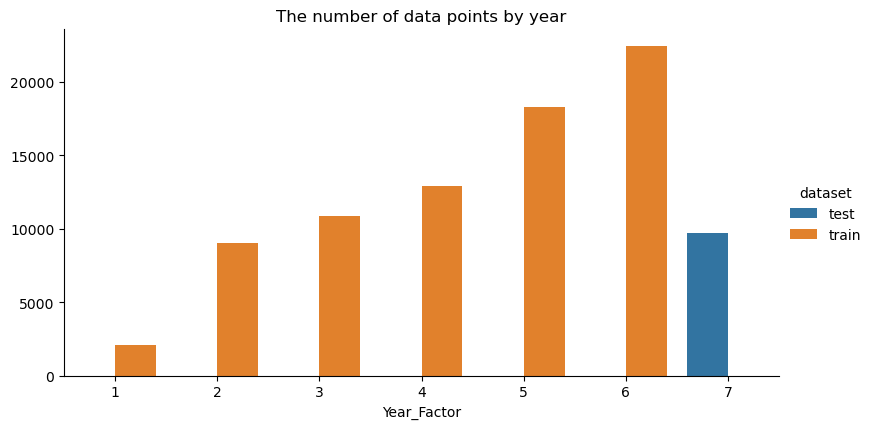

In [23]:
ax = sns.catplot(x='Year_Factor',
                 y='id',
                 data = df_all.groupby(['dataset','Year_Factor']).agg({'id':'count'}).reset_index(),
                hue='dataset',
                kind='bar',
                aspect=2,
                height=4
                )
ax.set(title="The number of data points by year",
     ylabel=None)
plt.show()

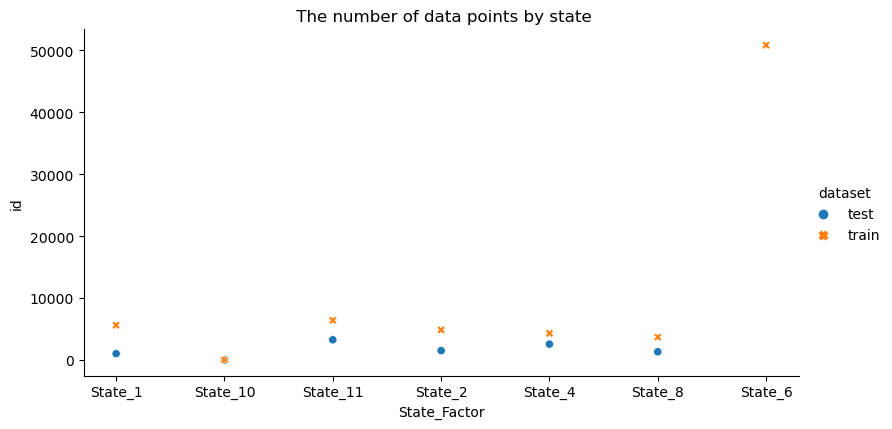

In [24]:
ax = sns.relplot(x='State_Factor',
                 y='id',
                 data=df_all.groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=2,
                 height=4)
ax.set(title= ' The number of data points by state')
plt.show()

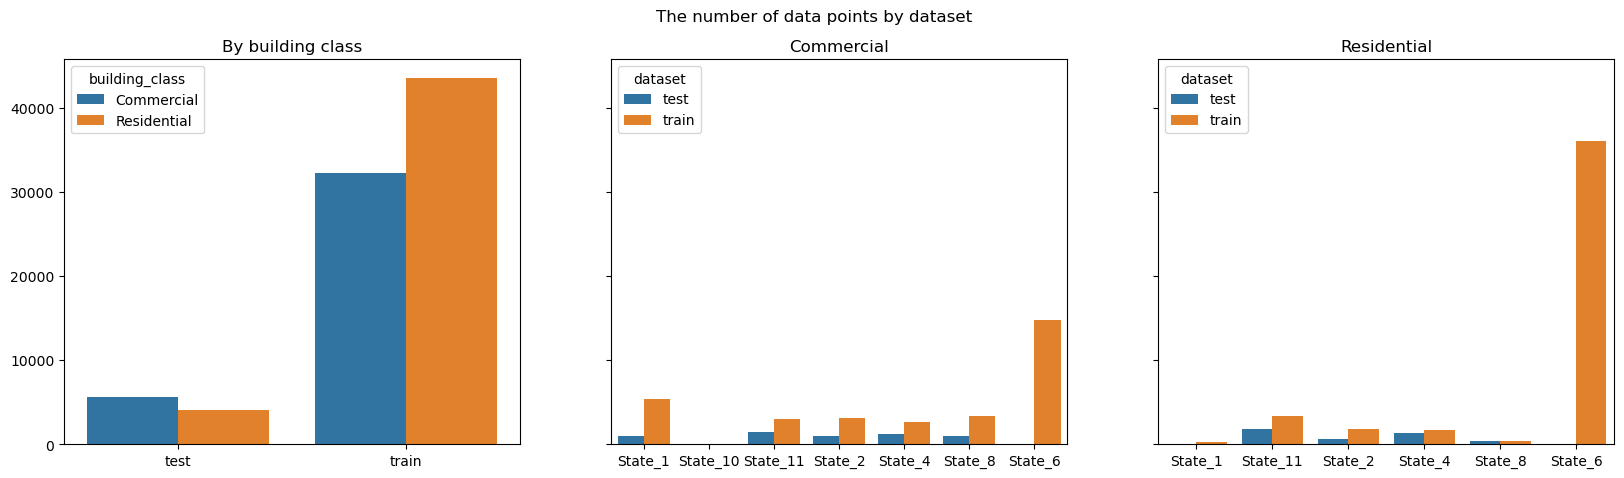

In [25]:
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
fig.suptitle("The number of data points by dataset")
sns.barplot(x='dataset',
            y='id',
            data=df_all.groupby(['dataset','building_class']).agg({'id':'count'}).reset_index(),
            hue='building_class',
            ax=ax[0],
            ci=False)
for e, s in enumerate(df_all['building_class'].unique(),1):
    sns.barplot(x='State_Factor',
                y='id',
                data=df_all[df_all['building_class']==s].groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                hue='dataset',
                ax=ax[e],
                ci=False)
    ax[e].set_title(s)
    ax[e].set_ylabel("")
    ax[e].set_xlabel("")
ax[0].set_title("By building class")
ax[0].set_ylabel("")
ax[0].set_xlabel("")
plt.show()

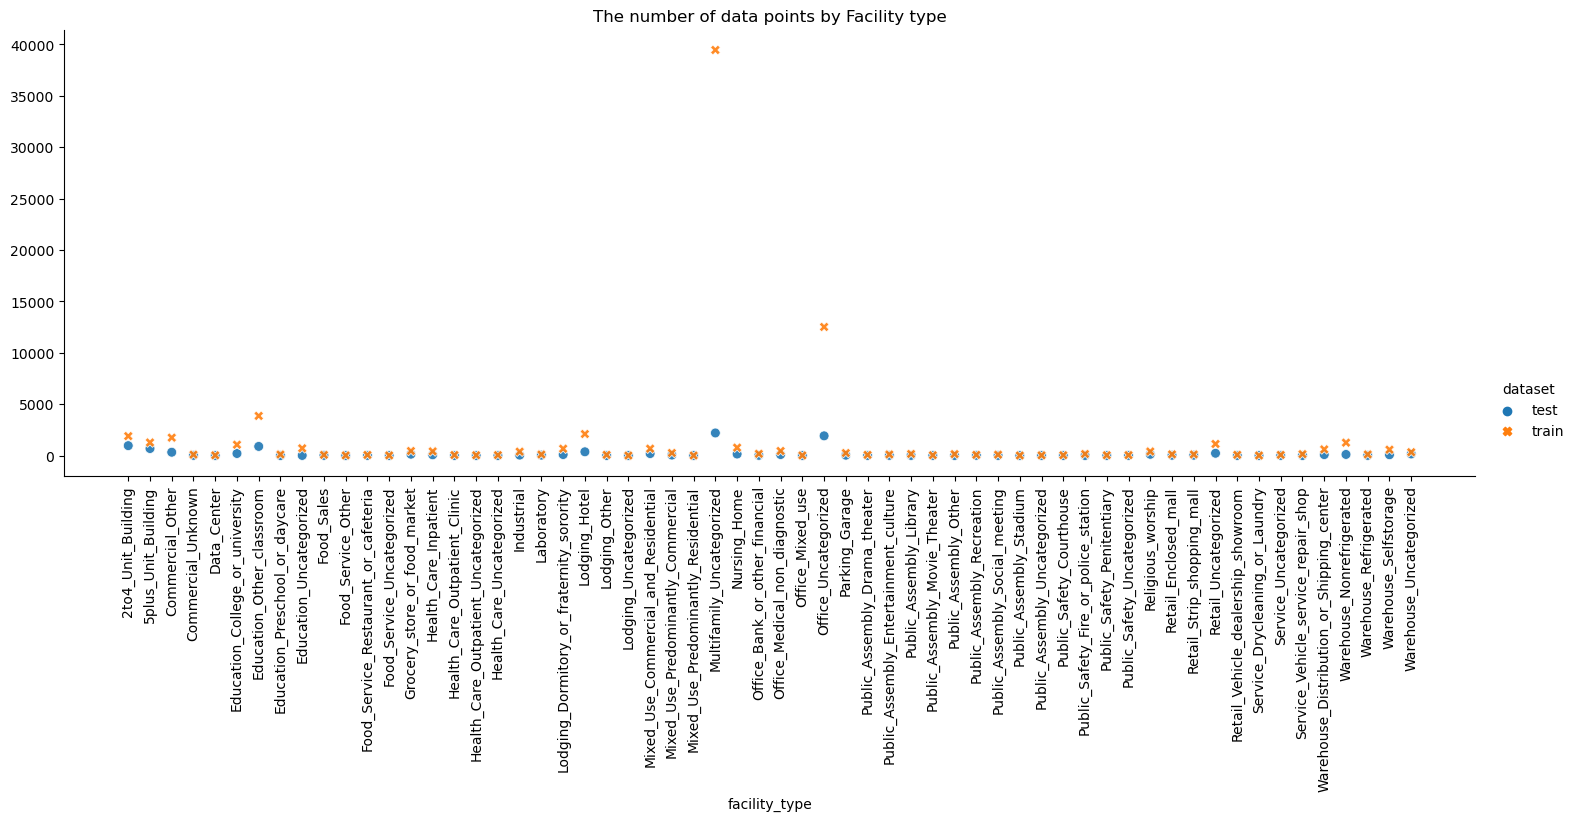

In [26]:
ax = sns.relplot(x='facility_type', 
                 y='id', 
                 data=df_all.groupby(['dataset','facility_type']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=3,
                 height=5,
                 s=50,
                 alpha=0.9
                )
ax.set(title = "The number of data points by Facility type",ylabel=None)
ax.set_xticklabels(rotation=90)
plt.show()

In [27]:
df_all['year_built'].value_counts().index.sort_values()

Float64Index([   0.0, 1600.0, 1649.0, 1732.0, 1756.0, 1789.0, 1799.0, 1800.0,
              1811.0, 1815.0,
              ...
              2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0,
              2015.0, 2016.0],
             dtype='float64', length=183)

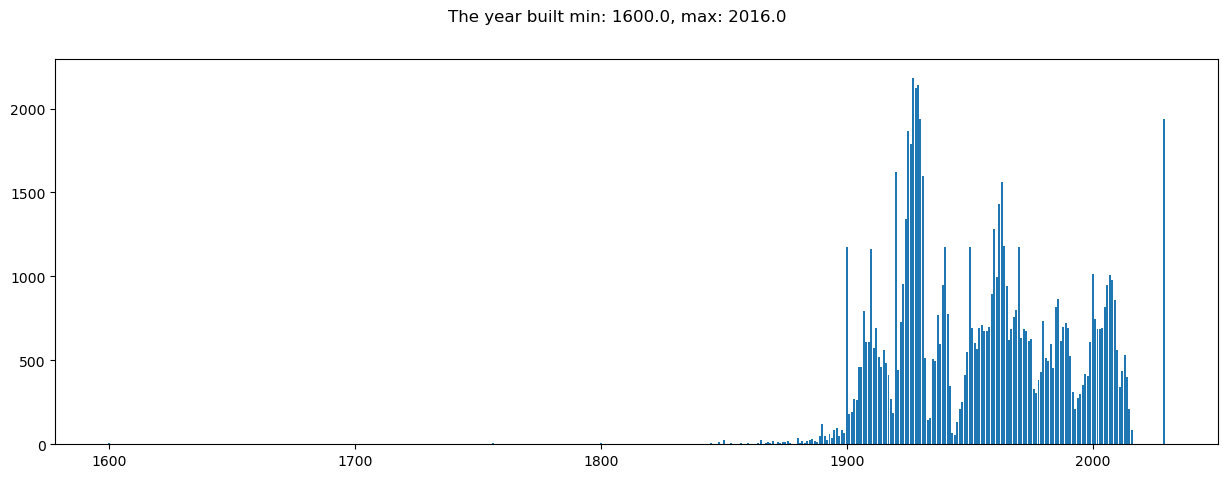

In [28]:
temp = df_all[['year_built']].fillna(2029).replace({0:2029}).astype('category').value_counts().reset_index().rename({0:'count'},axis=1)
temp.sort_values('year_built')
fig, ax = plt.subplots(figsize=(15,5))
ax=plt.bar(temp['year_built'],temp['count'])
fig.suptitle(f"The year built min: {min(temp['year_built'])}, max: {max(df_all['year_built'])}");
plt.show()

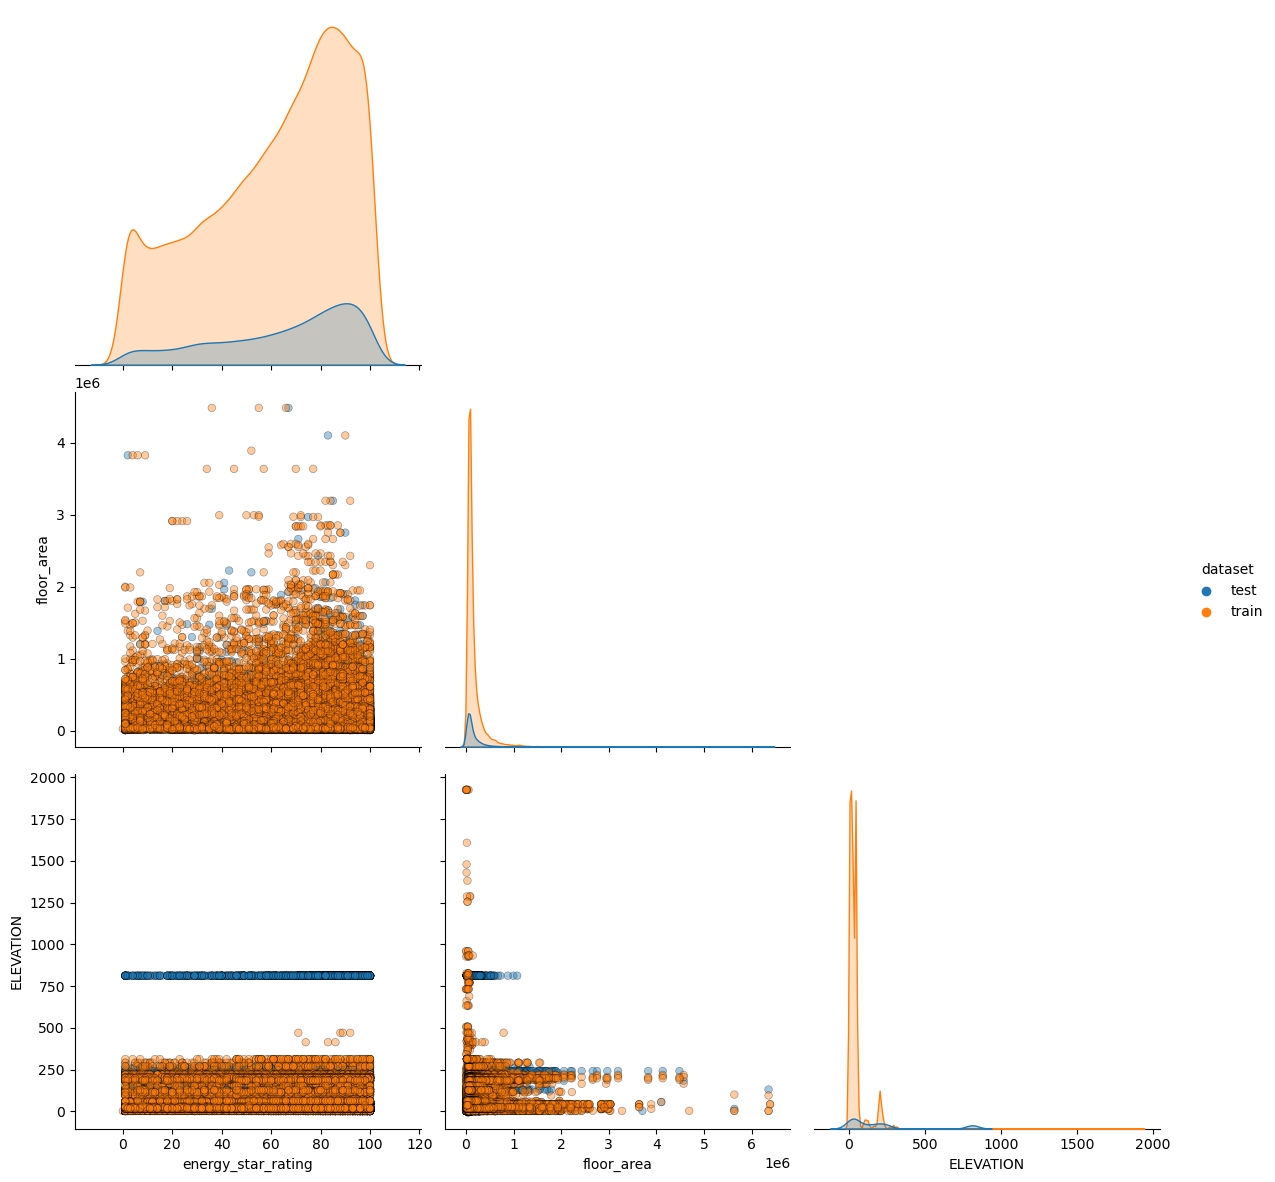

In [29]:
sns.pairplot(data=df_all,
             vars= ['energy_star_rating','floor_area','ELEVATION'],
             hue='dataset',
             height = 4,
             plot_kws = {'alpha': 0.4, 's': 30, 'edgecolor': 'k'},
             corner= True)
plt.show()

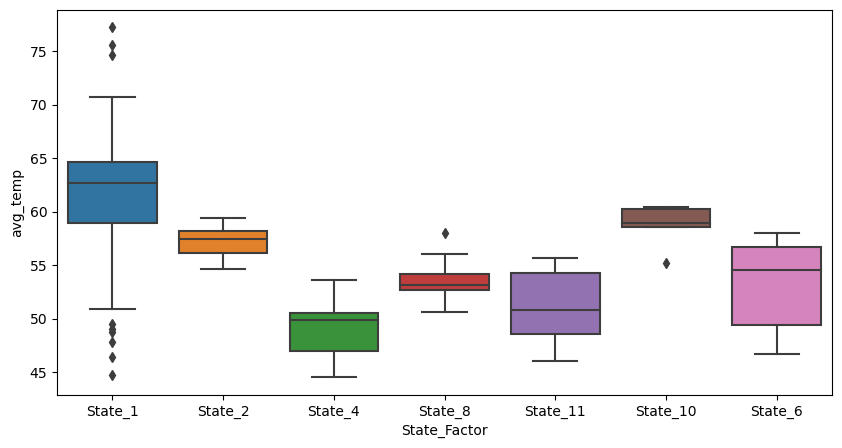

In [30]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df_all[['avg_temp','State_Factor']].drop_duplicates(), y='avg_temp', x='State_Factor');
plt.show()

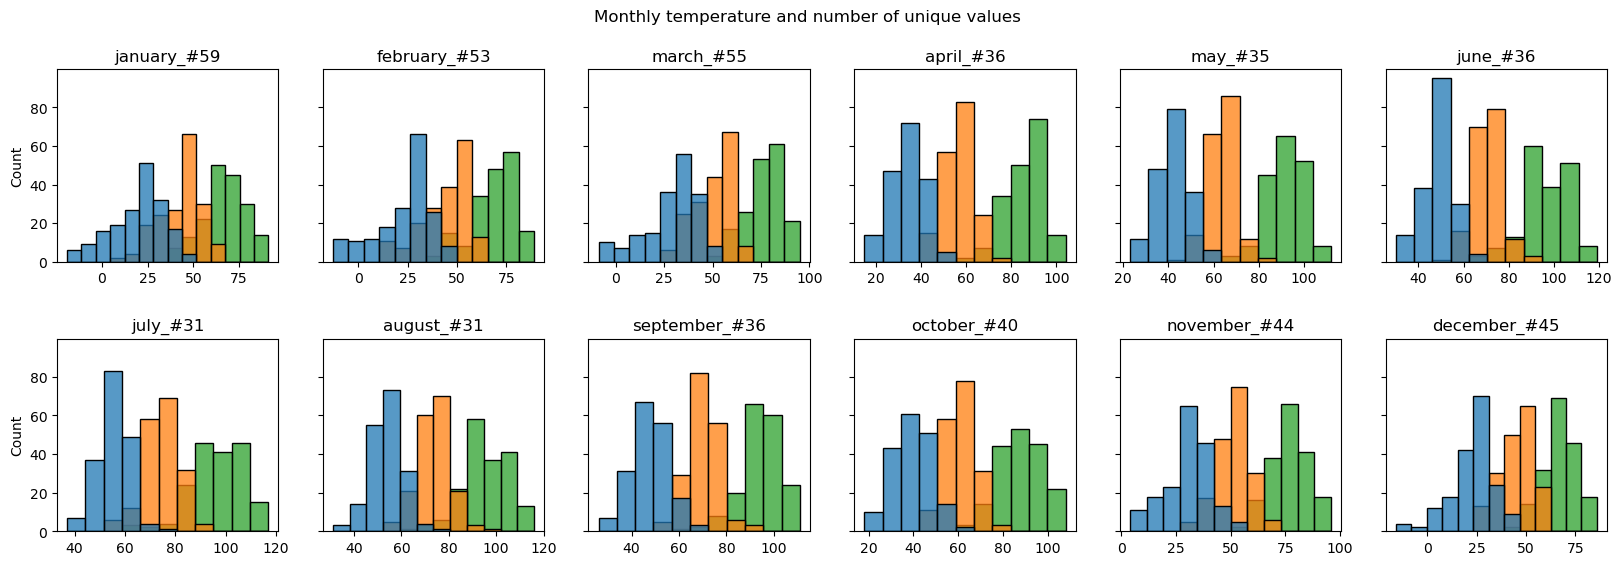

In [31]:
cols = [['january_min_temp', 'january_avg_temp', 'january_max_temp'],
        ['february_min_temp', 'february_avg_temp', 'february_max_temp'],
        ['march_min_temp', 'march_avg_temp', 'march_max_temp'], 
        ['april_min_temp','april_avg_temp', 'april_max_temp'], 
        ['may_min_temp', 'may_avg_temp','may_max_temp'], 
        ['june_min_temp', 'june_avg_temp', 'june_max_temp'],
        ['july_min_temp', 'july_avg_temp', 'july_max_temp'], 
        ['august_min_temp','august_avg_temp', 'august_max_temp'], 
        ['september_min_temp','september_avg_temp', 'september_max_temp'], 
        ['october_min_temp','october_avg_temp', 'october_max_temp'], 
        ['november_min_temp','november_avg_temp', 'november_max_temp'], 
        ['december_min_temp','december_avg_temp', 'december_max_temp']]
fig, ax = plt.subplots(2, 6, figsize=(20,6), sharey=True)
fig.suptitle("Monthly temperature and number of unique values")
for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[0,e], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[1,e-6], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
plt.subplots_adjust(hspace=0.4)
plt.show()

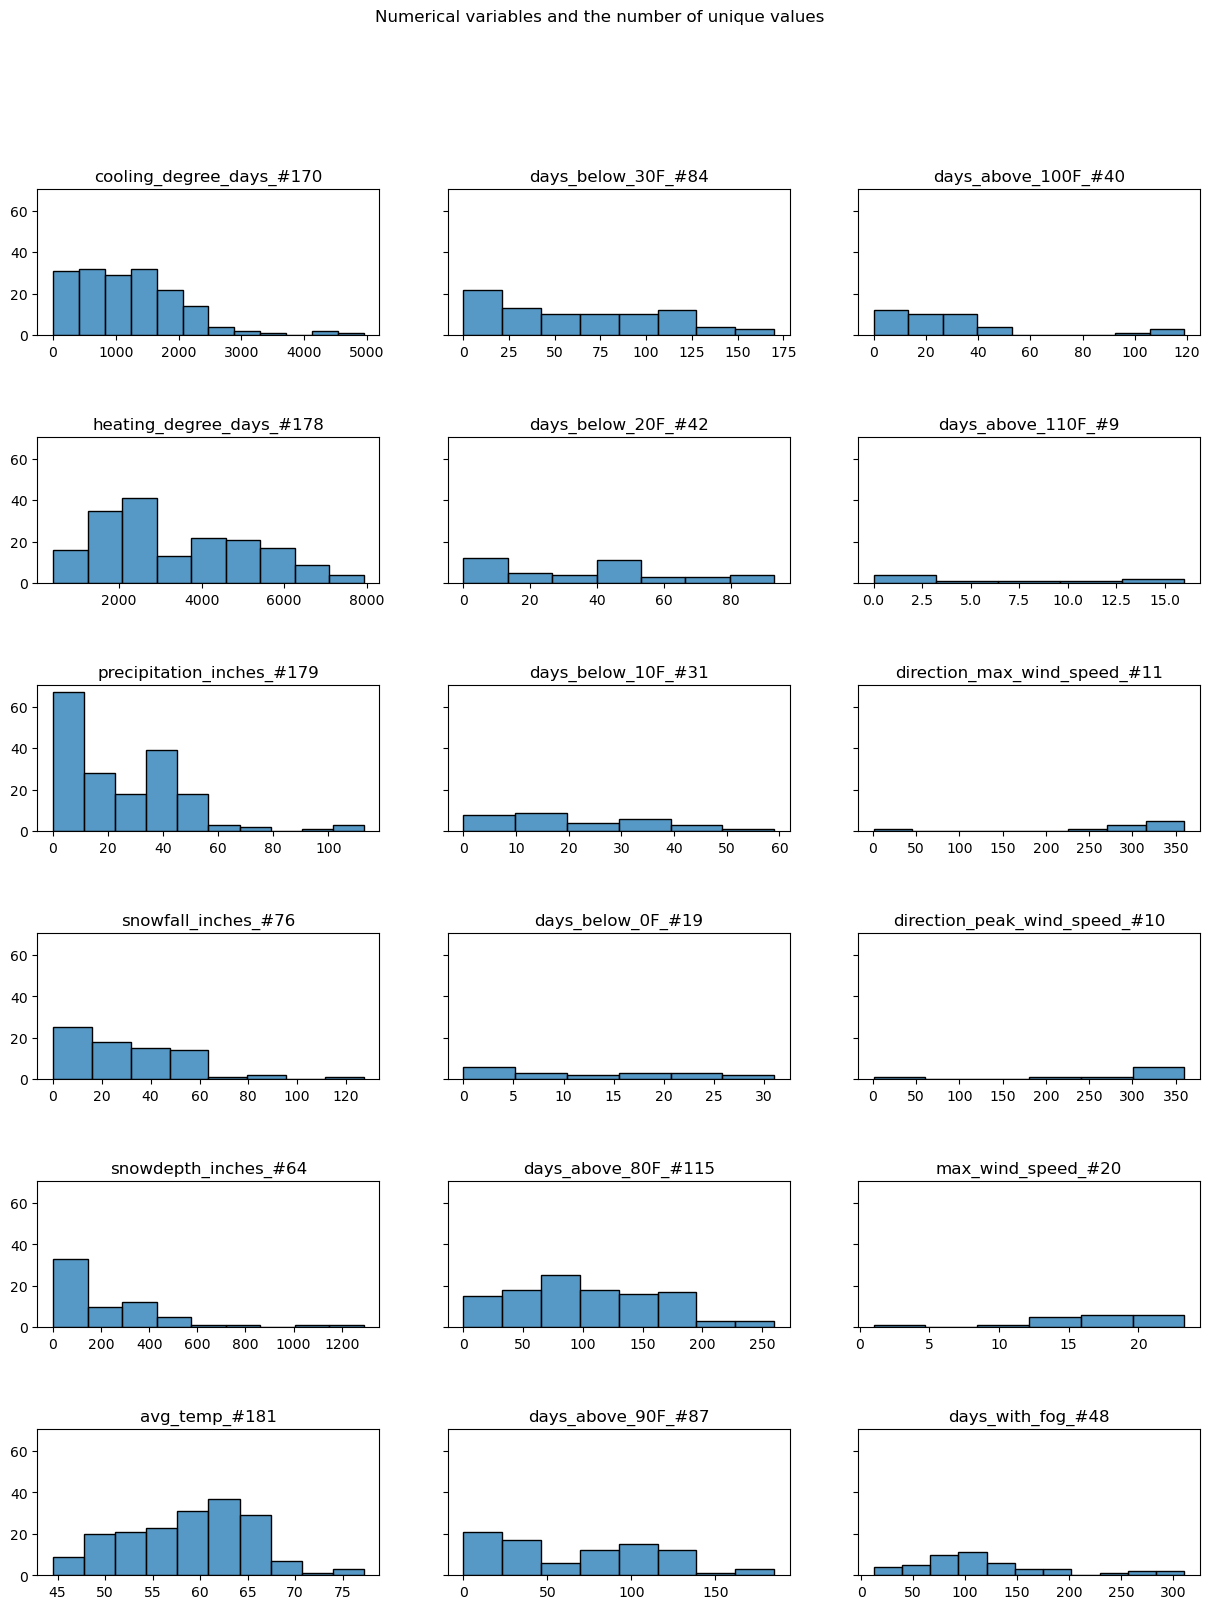

In [32]:
cols=['cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
       'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
fig, ax = plt.subplots(6,3, figsize=(15,18), sharey=True)
fig.suptitle("Numerical variables and the number of unique values")
for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e,0], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    elif (e>=6) & (e<=11):
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-6,1], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-12,2], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
plt.subplots_adjust(hspace=0.7)
plt.show()

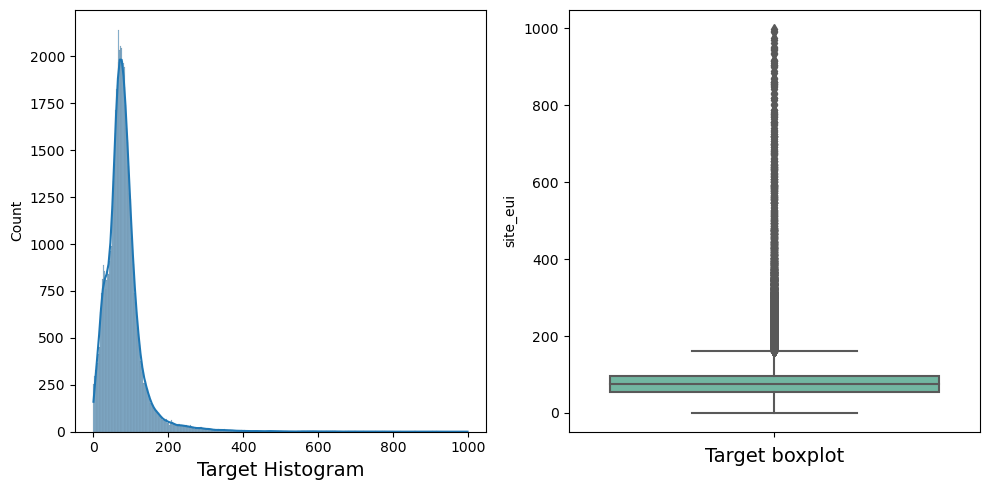

In [33]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
cp = sns.histplot(x=df_all['site_eui'], kde=True, palette='Set2')
ax1.set_xlabel('Target Histogram', fontsize=14)
ax2 = plt.subplot(1,2,2)
sns.boxplot(y=df_all['site_eui'], palette='Set2')
ax2.set_xlabel('Target boxplot', fontsize=14)
plt.tight_layout()
plt.show()

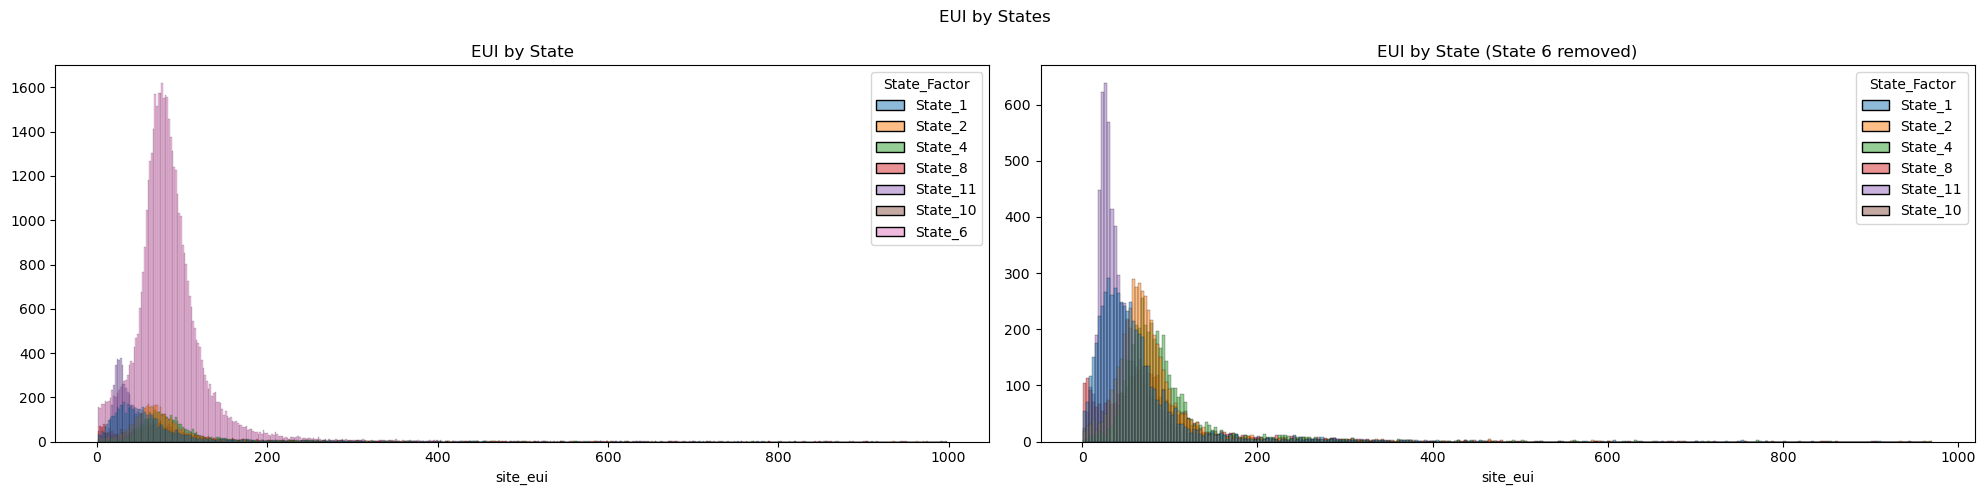

In [34]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle("EUI by States")
sns.histplot(df_all, x='site_eui',hue='State_Factor', ax=ax[0])
ax[0].set(title='EUI by State', ylabel=None)
sns.histplot(df_all[df_all['State_Factor']!='State_6'], x='site_eui', hue='State_Factor', ax=ax[1])
ax[1].set(title='EUI by State (State 6 removed)', ylabel=None);
plt.tight_layout()
plt.show()

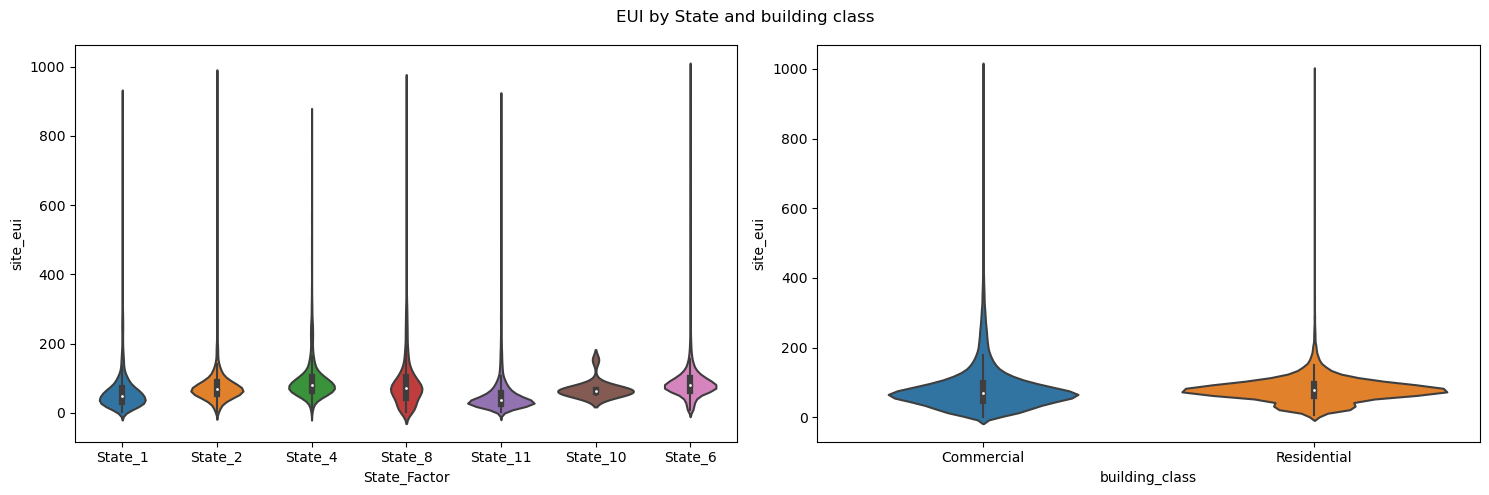

In [35]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("EUI by State and building class")
sns.violinplot(data=df_all, y='site_eui', x='State_Factor', ax=ax[0])
sns.violinplot(data=df_all, y='site_eui', x='building_class', ax=ax[1])
plt.tight_layout()
plt.show()

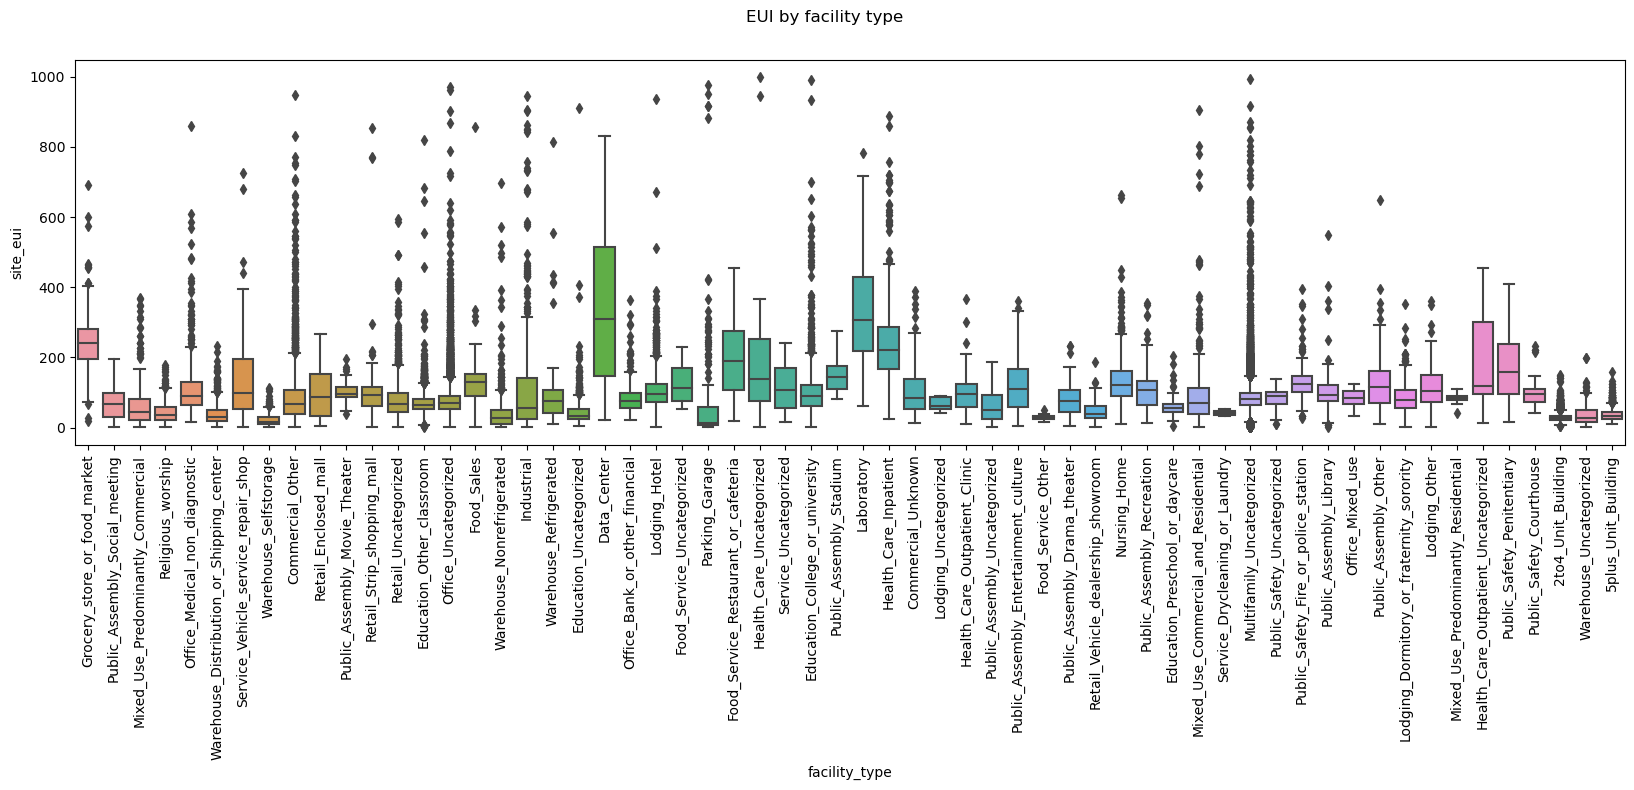

In [36]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle("EUI by facility type")
ax=sns.boxplot(data=df_all, y='site_eui', x='facility_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

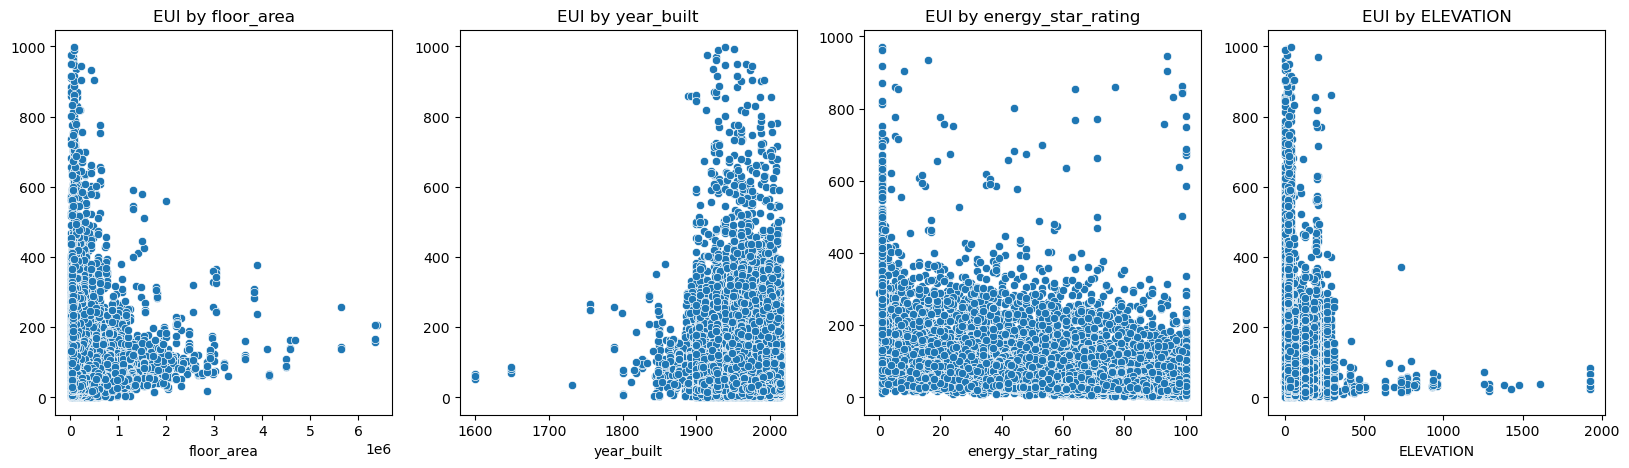

In [37]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
for e, col in enumerate(['floor_area', 'year_built', 'energy_star_rating', 'ELEVATION']):
    if col =='year_built':
        sns.scatterplot(data=df_all[(df_all['year_built']!=0) & (df_all['year_built'].notna())], 
                        x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None)
    else:
        sns.scatterplot(data=df_all, x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None)
plt.show()

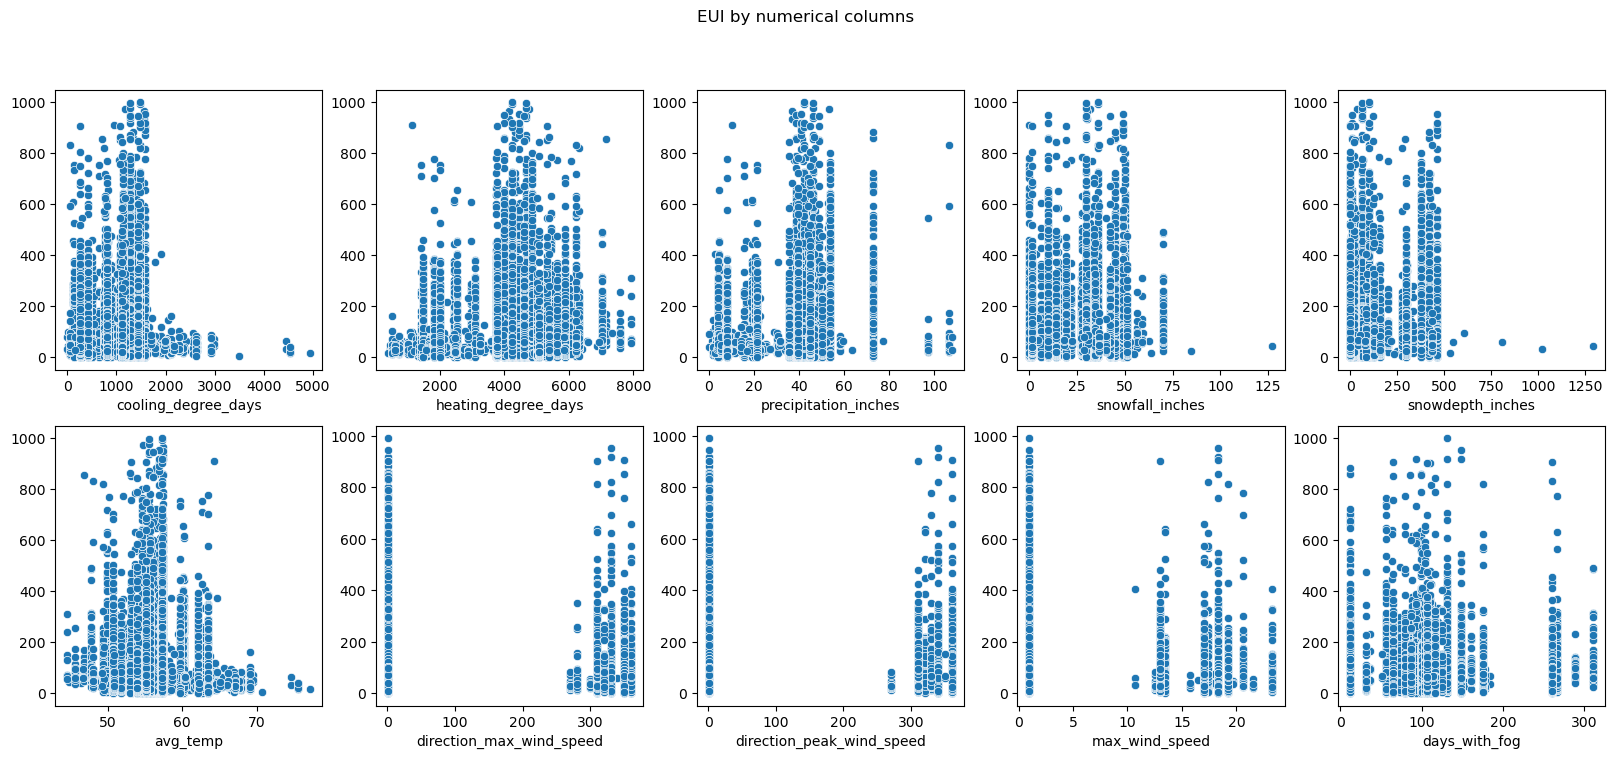

In [38]:
cols=[['cooling_degree_days','heating_degree_days', 'precipitation_inches', 
      'snowfall_inches','snowdepth_inches'], 
      ['avg_temp', 
      'direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed', 
      'days_with_fog']]
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('EUI by numerical columns')
for e1, l in enumerate(cols):
    for e2, col in enumerate(l):
        sns.scatterplot(data=df_all, 
                        x=col, y='site_eui', ax=ax[e1, e2]).set(ylabel=None)
plt.show()

In [39]:
groupby_cols = ['State_Factor','building_class','facility_type','floor_area','year_built']
df_all = df_all.sort_values(by=groupby_cols+['Year_Factor']).reset_index(drop=True)

In [40]:
df_all.loc[:,df_all.dtypes == 'object'].columns

Index(['State_Factor', 'building_class', 'facility_type', 'dataset'], dtype='object')

In [41]:
cats = ['State_Factor','facility_type','building_class']
for col in cats:
    dummies = pd.get_dummies(df_all[col],dummy_na=False)
    for ohe_col in dummies:
        df_all[f'ohe_{col}_{ohe_col}'] = dummies[ohe_col]

In [42]:
df_all

Year_Factor State_Factor building_class              facility_type  \
0                3      State_1     Commercial           Commercial_Other   
1                4      State_1     Commercial           Commercial_Other   
2                5      State_1     Commercial           Commercial_Other   
3                7      State_1     Commercial           Commercial_Other   
4                3      State_1     Commercial           Commercial_Other   
...            ...          ...            ...                        ...   
85457            7      State_8    Residential  Multifamily_Uncategorized   
85458            6      State_8    Residential  Multifamily_Uncategorized   
85459            7      State_8    Residential  Multifamily_Uncategorized   
85460            6      State_8    Residential  Multifamily_Uncategorized   
85461            7      State_8    Residential  Multifamily_Uncategorized   

       floor_area  year_built  energy_star_rating  ELEVATION  \
0         10149.0      1931.0                 NaN       45.7   
1         10149.0      1931.0                 NaN      120.4   
2         10149.0      1931.0                 NaN       59.1   
3         10149.0      1931.0                 NaN       59.1   
4         10755.0      1937.0                 NaN        9.1   
...           ...         ...                 ...        ...   
85457    900000.0      1960.0                90.0      130.8   
85458   1179072.0      1959.0                96.0        3.0   
85459   1179072.0      1959.0                92.0      130.8   
85460   1195034.0      1964.0                75.0        3.0   
85461   1195034.0      1964.0                77.0      130.8   

       january_min_temp  january_avg_temp  ...  \
0                    26         44.516129  ...   
1                    41         55.096774  ...   
2                    29         51.387097  ...   
3                    38         50.596774  ...   
4                    22         44.790323  ...   
...                 ...               ...  ...   
85457                 2         33.435484  ...   
85458                 8         29.827586  ...   
85459                 2         33.435484  ...   
85460                 8         29.827586  ...   
85461                 2         33.435484  ...   

       ohe_facility_type_Service_Drycleaning_or_Laundry  \
0                                                     0   
1                                                     0   
2                                                     0   
3                                                     0   
4                                                     0   
...                                                 ...   
85457                                                 0   
85458                                                 0   
85459                                                 0   
85460                                                 0   
85461                                                 0   

       ohe_facility_type_Service_Uncategorized  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   
...                                        ...   
85457                                        0   
85458                                        0   
85459                                        0   
85460                                        0   
85461                                        0   

       ohe_facility_type_Service_Vehicle_service_repair_shop  \
0                                                      0       
1                                                      0       
2                                                      0       
3                                                      0       
4                                                      0       
...               

In [43]:
iter_imputing = True
target='site_eui'

if iter_imputing:
    imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df = df_all.drop(tmp.columns, axis=1)
    df1 = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
    
    tmp.to_csv('data/imputer_tmp.csv', index=False)
    df1.to_csv('data/imputer_df1.csv', index=False)
    joblib.dump(imputer, '/home/abhishek/Desktop/Site_EUI_Prediction/models/iter_imputer.pkl')
    

In [44]:
df1 = pd.read_csv('data/imputer_df1.csv')
tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
df_all = df_all.drop(tmp.columns, axis=1)
for col in tmp.columns:
    df_all[col]=tmp[col]
for col in df1.columns:
    df_all[col] = df1[col]

In [45]:
target='site_eui'
cats = ['State_Factor', 'building_class', 'facility_type']
for col in cats:
    encoder = TargetEncoder()
    df_all[f'te_{col}'] = encoder.fit_transform(df_all[col], df_all[target])

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [46]:
temp = [col for col in df_all.columns if 'temp' in col]
df_all['min_temp'] = df_all[temp].min(axis=1)
df_all['max_temp'] = df_all[temp].max(axis=1)
df_all['avg_temp'] = df_all[temp].mean(axis=1)
df_all['std_temp'] = df_all[temp].std(axis=1)
df_all['skew_temp'] = df_all[temp].skew(axis=1)
temp = pd.Series([col for col in df_all.columns if 'temp' in col])
winter_temp = temp[temp.apply(lambda x: ('january' in x or 'february' in x or 'december' in x))].values
spring_temp = temp[temp.apply(lambda x: ('march' in x or 'april' in x or 'may' in x))].values
summer_temp = temp[temp.apply(lambda x: ('june' in x or 'july' in x or 'august' in x))].values
autumn_temp = temp[temp.apply(lambda x: ('september' in x or 'october' in x or 'november' in x))].values
df_all['min_winter_temp'] = df_all[winter_temp].min(axis=1)
df_all['max_winter_temp'] = df_all[winter_temp].max(axis=1)
df_all['avg_winter_temp'] = df_all[winter_temp].mean(axis=1)
df_all['std_winter_temp'] = df_all[winter_temp].std(axis=1)
df_all['skew_winter_temp'] = df_all[winter_temp].skew(axis=1)
df_all['min_spring_temp'] = df_all[spring_temp].min(axis=1)
df_all['max_spring_temp'] = df_all[spring_temp].max(axis=1)
df_all['avg_spring_temp'] = df_all[spring_temp].mean(axis=1)
df_all['std_spring_temp'] = df_all[spring_temp].std(axis=1)
df_all['skew_spring_temp'] = df_all[spring_temp].skew(axis=1)
df_all['min_summer_temp'] = df_all[summer_temp].min(axis=1)
df_all['max_summer_temp'] = df_all[summer_temp].max(axis=1)
df_all['avg_summer_temp'] = df_all[summer_temp].mean(axis=1)
df_all['std_summer_temp'] = df_all[summer_temp].std(axis=1)
df_all['skew_summer_temp'] = df_all[summer_temp].skew(axis=1)
df_all['min_autumn_temp'] = df_all[autumn_temp].min(axis=1)
df_all['max_autumn_temp'] = df_all[autumn_temp].max(axis=1)
df_all['avg_autumn_temp'] = df_all[autumn_temp].mean(axis=1)
df_all['std_autumn_temp'] = df_all[autumn_temp].std(axis=1)
df_all['skew_autumn_temp'] = df_all[autumn_temp].skew(axis=1)

In [47]:
df_all['month_cooling_degree_days'] = df_all['cooling_degree_days']/12
df_all['month_heating_degree_days'] = df_all['heating_degree_days']/12

In [48]:
df_all['building_area'] = df_all['floor_area'] * df_all['ELEVATION']
df_all['floor_energy_star_rating'] = df_all['energy_star_rating']/df_all['ELEVATION']

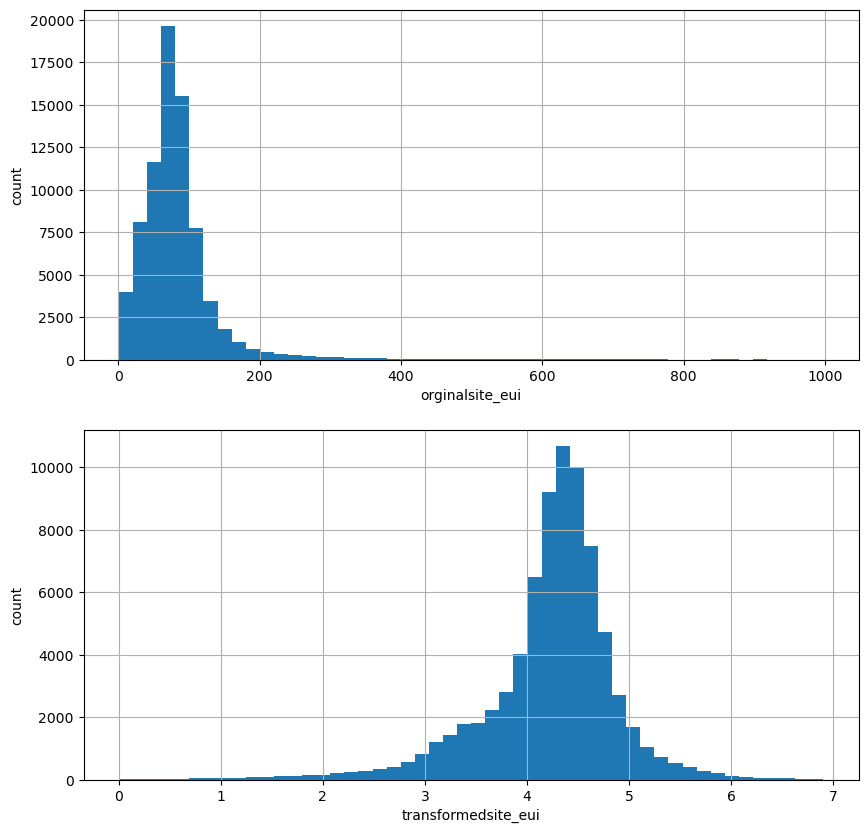

In [49]:
target = 'site_eui'
plt.figure(figsize = (10,10))
plt.subplot(2,1,1)
train[target].hist(bins=50)
plt.ylabel('count')
plt.xlabel('orginal' + target)
plt.subplot(2,1,2)
np.log(train[target]).hist(bins=50)
plt.ylabel('count')
plt.xlabel('transformed' + target)
plt.show()

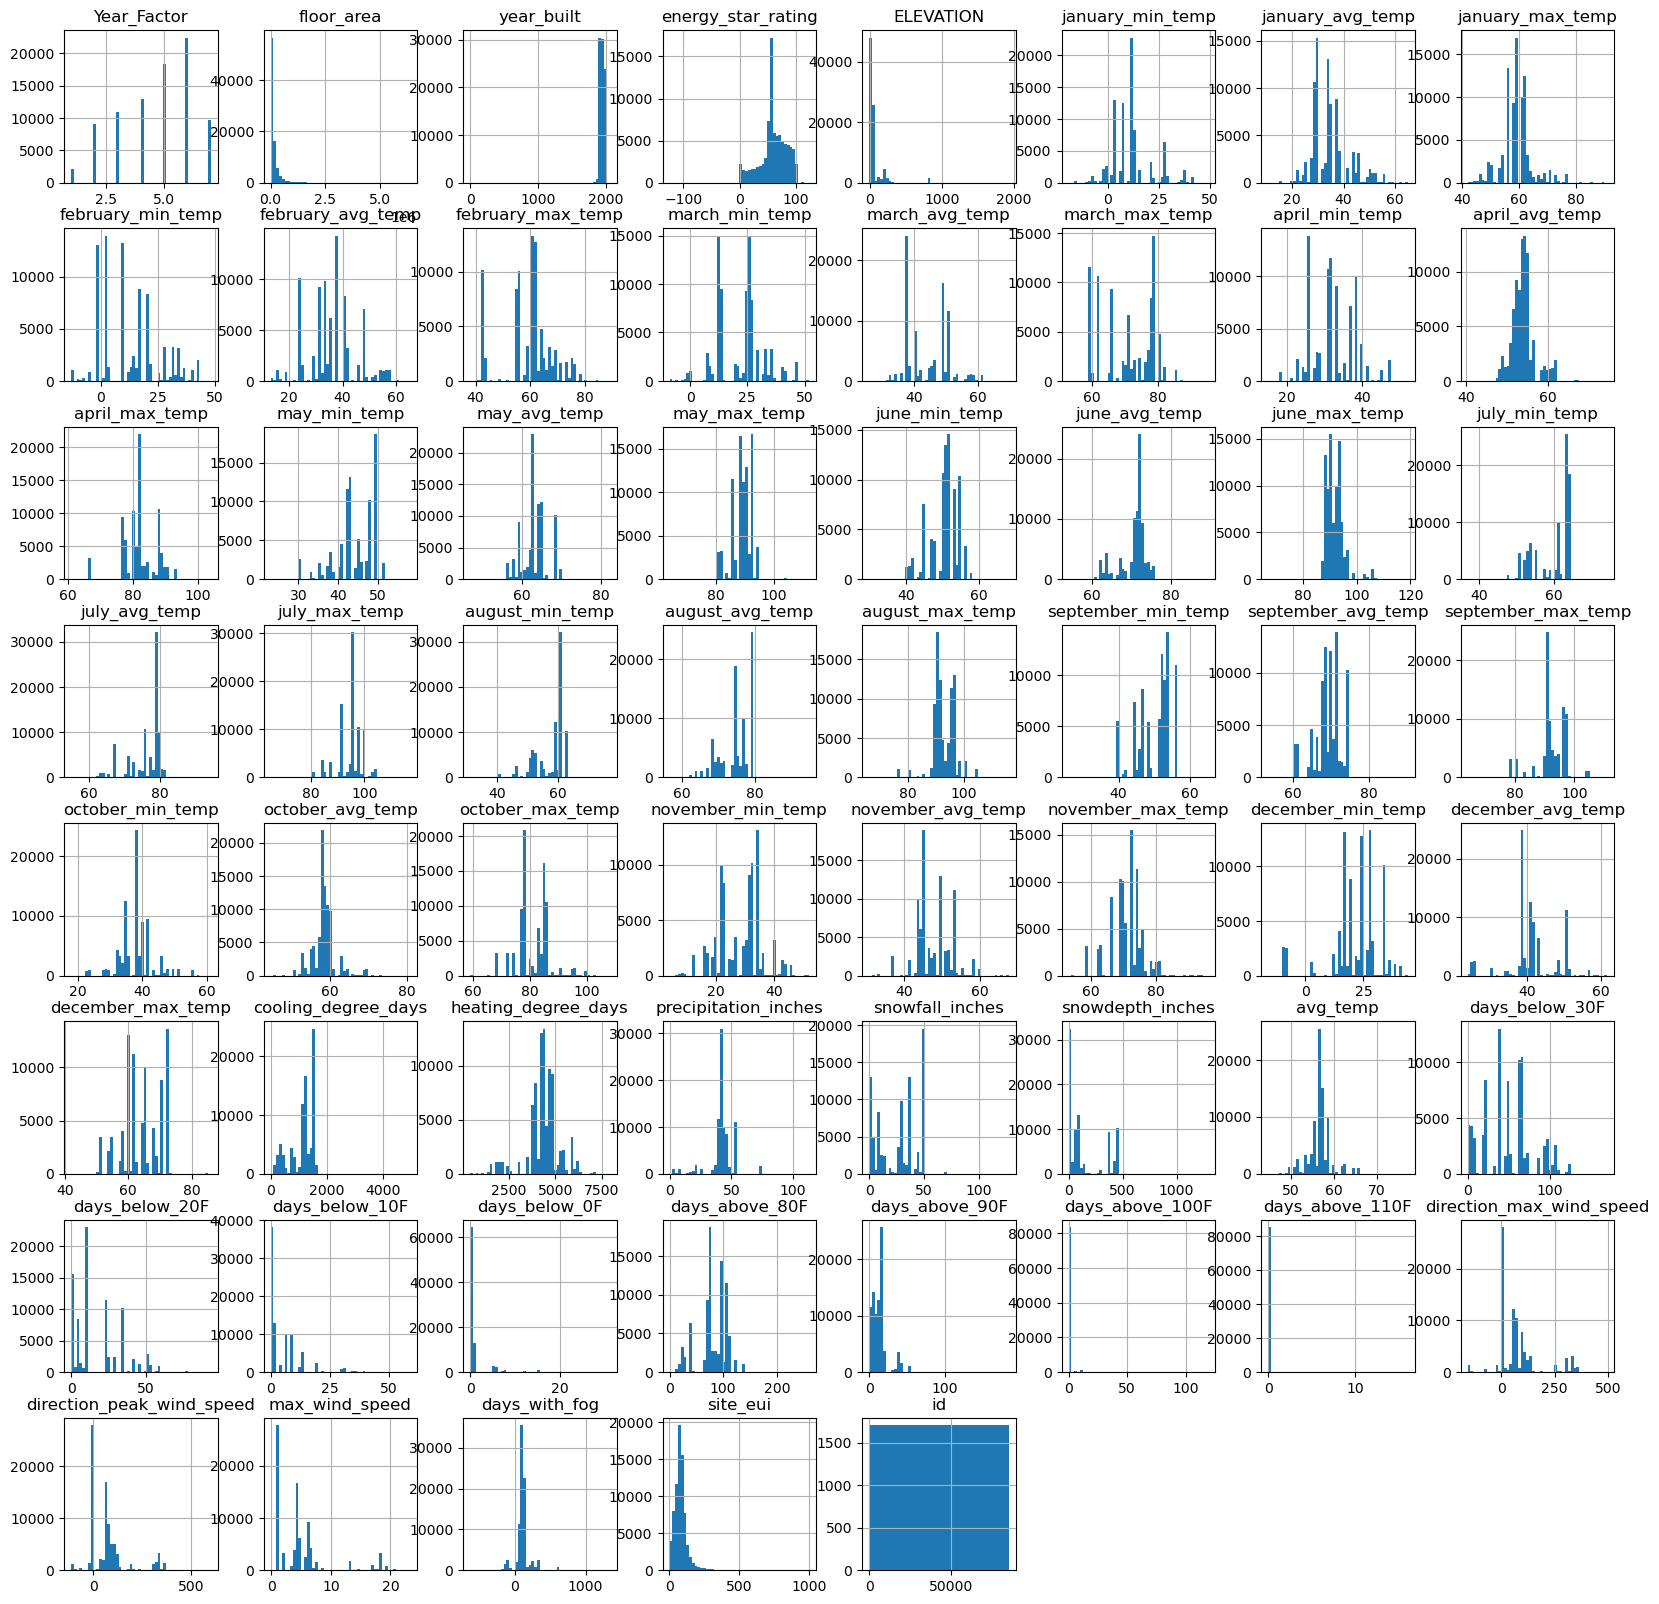

In [50]:
nums = train.loc[:,train.dtypes != 'object'].columns
df_all[nums].hist(bins = 50,figsize = (20,20))
plt.show()

In [51]:
df_all[nums].skew().sort_values(key=abs , ascending=False)[:5]

days_above_110F    89.873857
days_above_100F    24.615438
year_built        -11.257351
floor_area          6.701786
ELEVATION           5.140444
dtype: float64

In [52]:
skewed = ['days_above_110F', 'days_above_100F']
for var in skewed:
    df_all[var] = np.where(df_all[var]==0, 0, 1)

In [53]:
df_all.to_pickle('data/feature_transformed_set.pkl')

In [54]:
df_all.shape

(85462, 165)

In [55]:
df_all.head()

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
0          3.0     10149.0      1931.0           69.141207       45.7   
1          4.0     10149.0      1931.0           69.864237      120.4   
2          5.0     10149.0      1931.0           71.970461       59.1   
3          7.0     10149.0      1931.0           74.499274       59.1   
4          3.0     10755.0      1937.0           70.446695        9.1   

   january_min_temp  january_avg_temp  january_max_temp  february_min_temp  \
0              26.0         44.516129              64.0               30.0   
1              41.0         55.096774              73.0               42.0   
2              29.0         51.387097              77.0               36.0   
3              38.0         50.596774              64.0               40.0   
4              22.0         44.790323              65.0               25.0   

   february_avg_temp  ...  skew_summer_temp  min_autumn_temp  max_autumn_temp  \
0          49.392857  ...          0.377041             36.0             98.0   
1          54.875000  ...          0.430796             46.0             95.0   
2          56.803571  ...          0.404631             29.0            105.0   
3          54.482143  ...          0.628608             43.0            104.0   
4          47.892857  ...          0.247420             31.0             96.0   

   avg_autumn_temp  std_autumn_temp  skew_autumn_temp  \
0        63.361111        20.462133          0.360253   
1        67.521625        15.342943          0.494753   
2        67.003405        23.881873          0.162329   
3        66.778913        19.843743          0.883927   
4        60.048268        22.548770          0.276234   

   month_cooling_degree_days  month_heating_degree_days  building_area  \
0                  68.833333                 211.833333       463809.3   
1                  41.416667                 123.083333      1221939.6   
2                 109.916667                 151.916667       599805.9   
3                  28.500000                 176.000000       599805.9   
4                  25.250000                 259.000000        97870.5   

   floor_energy_star_rating  
0                  1.512937  
1                  0.580268  
2                  1.217774  
3                  1.260563  
4                  7.741395  

[5 rows x 165 columns]

In [56]:
cats = ['State_Factor', 'facility_type', 'building_class', 'days_above_100F', 'days_above_110F']
for col in df_all.drop(columns=cats + ['dataset', 'id', 'site_eui']).columns:
    df_all[col] = df_all[col].astype('float64')

In [57]:
df_all.drop(columns=cats)

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
0              3.0     10149.0      1931.0           69.141207       45.7   
1              4.0     10149.0      1931.0           69.864237      120.4   
2              5.0     10149.0      1931.0           71.970461       59.1   
3              7.0     10149.0      1931.0           74.499274       59.1   
4              3.0     10755.0      1937.0           70.446695        9.1   
...            ...         ...         ...                 ...        ...   
85457          7.0    900000.0      1960.0           90.000000      130.8   
85458          6.0   1179072.0      1959.0           96.000000        3.0   
85459          7.0   1179072.0      1959.0           92.000000      130.8   
85460          6.0   1195034.0      1964.0           75.000000        3.0   
85461          7.0   1195034.0      1964.0           77.000000      130.8   

       january_min_temp  january_avg_temp  january_max_temp  \
0                  26.0         44.516129              64.0   
1                  41.0         55.096774              73.0   
2                  29.0         51.387097              77.0   
3                  38.0         50.596774              64.0   
4                  22.0         44.790323              65.0   
...                 ...               ...               ...   
85457               2.0         33.435484              61.0   
85458               8.0         29.827586              62.0   
85459               2.0         33.435484              61.0   
85460               8.0         29.827586              62.0   
85461               2.0         33.435484              61.0   

       february_min_temp  february_avg_temp  ...  skew_summer_temp  \
0                   30.0          49.392857  ...          0.377041   
1                   42.0          54.875000  ...          0.430796   
2                   36.0          56.803571  ...          0.404631   
3                   40.0          54.482143  ...          0.628608   
4                   25.0          47.892857  ...          0.247420   
...                  ...                ...  ...               ...   
85457               16.0          37.660714  ...         -0.302702   
85458                4.0          33.896552  ...         -0.205982   
85459               16.0          37.660714  ...         -0.302702   
85460                4.0          33.896552  ...         -0.205982   
85461               16.0          37.660714  ...         -0.302702   

       min_autumn_temp  max_autumn_temp  avg_autumn_temp  std_autumn_temp  \
0                 36.0             98.0        63.361111        20.462133   
1                 46.0             95.0        67.521625        15.342943   
2                 29.0            105.0        67.003405        23.881873   
3                 43.0            104.0        66.778913        19.843743   
4                 31.0             96.0        60.048268        22.548770   
...                ...              ...              ...              ...   
85457             17.0             91.0        55.995818        24.752362   
85458             20.0             96.0        55.974970        26.286606   
85459             17.0             91.0        55.995818        24.752362   
85460             20.0             96.0        55.974970        26.286606   
85461             17.0             91.0        55.995818        24.752362   

       skew_autumn_temp  month_cooling_degree_days  month_heating_degree_days  \
0              0.360253                  68.833333                 211.833333   
1              0.494753                  41.416667                 123.083333   
2              0.162329                 109.916667                 151.916667   
3              0.883927                  28.500000                 176.000000   
4              0.276234                  25.250000                 259.000000   
...                 ...                        ...                       

In [58]:
train = df_all[df_all['dataset'] == 'train']
test = df_all[df_all['dataset'] == 'test']
train.reset_index(drop = True)
test.reset_index(drop = True)
test_ids = test['id']
train_ids = train['id']
target = train['site_eui']
train = train.drop(['dataset','id','site_eui'],axis =1)
test = test.drop(['dataset','id','site_eui'],axis = 1)

In [59]:
cats_discrete_idx = np.where(train.dtypes != 'float64')[0]
le = LabelEncoder()
for col_idx in cats_discrete_idx:
    train.iloc[:, col_idx] = le.fit_transform(train.iloc[:, col_idx].astype(str))
    test.iloc[:, col_idx] = le.transform(test.iloc[:, col_idx].astype(str))

In [60]:
print('label encoded columns are:- ')
for i in cats_discrete_idx:
    print(train.columns[i])

label encoded columns are:- 
days_above_100F
days_above_110F
State_Factor
building_class
facility_type


In [61]:
y_test = pd.read_csv('y_test.csv')
X_train = train
X_test = test
y_train = target
y_test = y_test['site_eui']
print('Train: ', X_train.shape)
print('Test:', X_test.shape)
print('Samples: ', y_train.shape)
print('Targets: ', y_test.shape)

Train:  (75757, 162)
Test: (9705, 162)
Samples:  (75757,)
Targets:  (9705,)


In [62]:
catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)

In [63]:
catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)
y_pred = catb.predict(X_test)

0:	learn: 57.8198217	test: 61.1764641	best: 61.1764641 (0)	total: 367ms	remaining: 3m 2s
75:	learn: 44.2527931	test: 68.2780516	best: 61.1764641 (0)	total: 23.7s	remaining: 2m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 61.17646409
bestIteration = 0

Shrink model to first 1 iterations.


In [64]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 61.17646411435035
 MAE: 40.265945754925255
 MSE: 3742.5597615343963
 R2: -0.035092247329476134


In [65]:
xgb = XGBRegressor(n_estimators=500, reg_alpha=0.01, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [66]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 81.92601061591321
 MAE: 53.648017291760944
 MSE: 6711.871215438725
 R2: -0.8563246288220006


In [67]:
rf = RandomForestRegressor(random_state=1, criterion='mse', max_depth = 15, min_samples_split= 2)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.


In [68]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 76.78783517388142
 MAE: 49.27301887845489
 MSE: 5896.37163069118
 R2: -0.6307791862219028


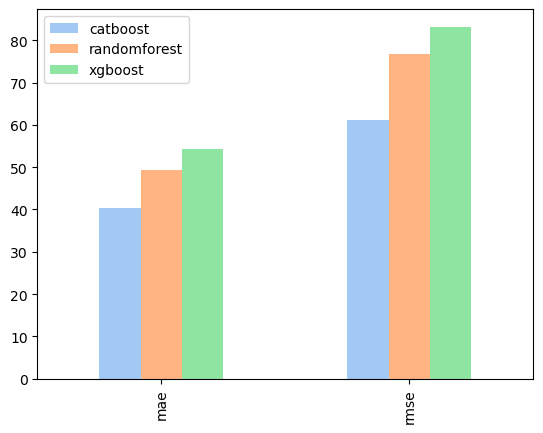

In [69]:
error_rec = {
    "catboost": {
        "mae": 40.265945754925255,
        "rmse": 61.17646411435035,
    },
    "randomforest": {
        "mae": 49.29643995301371,
        "rmse": 76.73510630794756,
    },
    "xgboost": {
        "mae": 54.33754245906833,
        "rmse": 83.2253602056894,
    },
}
pd.DataFrame(error_rec).plot(kind="bar", 
             color=[
                 sns.color_palette("pastel")[0], 
                 sns.color_palette("pastel")[1], 
                 sns.color_palette("pastel")[2], 
                 sns.color_palette("pastel")[3]])
plt.show()

In [70]:
train_oof = np.zeros((train.shape[0],))
test_preds = np.zeros(test.shape[0])
NUM_FOLDS = 5
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for fold, (train_idx, test_idx) in tqdm.tqdm(enumerate(kf.split(train, target))):
    X_train, X_test = train.iloc[train_idx][test.columns], train.iloc[test_idx][test.columns]
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
    
    catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)
    catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)
    oof = catb.predict(X_test)
    train_oof[test_idx] = oof
    test_preds += catb.predict(test)/NUM_FOLDS      
    print(f"out-of-folds prdiction ==== fold_{fold} RMSE",np.sqrt(mean_squared_error(oof, y_test, squared=False)))


0it [00:00, ?it/s]Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


0:	learn: 58.0485502	test: 56.9980533	best: 56.9980533 (0)	total: 284ms	remaining: 2m 21s
75:	learn: 44.6797591	test: 44.3223209	best: 44.3223209 (75)	total: 20.8s	remaining: 1m 56s
150:	learn: 41.5493072	test: 42.1126294	best: 42.1126294 (150)	total: 41.1s	remaining: 1m 35s
225:	learn: 40.2164143	test: 41.5306023	best: 41.5306023 (225)	total: 1m 1s	remaining: 1m 14s
300:	learn: 39.2516159	test: 41.2378184	best: 41.2378184 (300)	total: 1m 22s	remaining: 54.3s
375:	learn: 38.6168776	test: 41.0501189	best: 41.0501189 (375)	total: 1m 41s	remaining: 33.5s
450:	learn: 37.9464292	test: 40.8485872	best: 40.8484197 (449)	total: 2m 2s	remaining: 13.3s
499:	learn: 37.5828020	test: 40.7734177	best: 40.7734177 (499)	total: 2m 16s	remaining: 0us

bestTest = 40.77341774
bestIteration = 499



1it [02:16, 136.76s/it]

out-of-folds prdiction ==== fold_0 RMSE 6.385406619745434


0:	learn: 57.9284631	test: 57.3779359	best: 57.3779359 (0)	total: 283ms	remaining: 2m 21s
75:	learn: 44.5276141	test: 44.8046754	best: 44.8046754 (75)	total: 21.8s	remaining: 2m 1s
150:	learn: 41.5287084	test: 42.8520902	best: 42.8520902 (150)	total: 43.4s	remaining: 1m 40s
225:	learn: 40.1347204	test: 42.1597467	best: 42.1597467 (225)	total: 1m 5s	remaining: 1m 19s
300:	learn: 39.2727504	test: 41.8301338	best: 41.8301338 (300)	total: 1m 27s	remaining: 57.6s
375:	learn: 38.5991334	test: 41.6184728	best: 41.6184728 (375)	total: 1m 49s	remaining: 36s
450:	learn: 37.9771043	test: 41.4420319	best: 41.4420319 (450)	total: 2m 12s	remaining: 14.4s
499:	learn: 37.6415378	test: 41.3658113	best: 41.3658113 (499)	total: 2m 25s	remaining: 0us

bestTest = 41.36581133
bestIteration = 499



2it [04:43, 142.48s/it]

out-of-folds prdiction ==== fold_1 RMSE 6.431625868061956


0:	learn: 57.6706026	test: 58.5630977	best: 58.5630977 (0)	total: 333ms	remaining: 2m 46s
75:	learn: 43.9178740	test: 46.9636557	best: 46.9636557 (75)	total: 24.7s	remaining: 2m 17s
150:	learn: 40.7702649	test: 45.2108565	best: 45.2108565 (150)	total: 48.3s	remaining: 1m 51s
225:	learn: 39.3601157	test: 44.7157673	best: 44.7157673 (225)	total: 1m 12s	remaining: 1m 28s
300:	learn: 38.3402846	test: 44.4743806	best: 44.4743806 (300)	total: 1m 36s	remaining: 1m 3s
375:	learn: 37.5749755	test: 44.3456522	best: 44.3456522 (375)	total: 2m	remaining: 39.8s
450:	learn: 36.9412617	test: 44.2693375	best: 44.2693375 (450)	total: 2m 24s	remaining: 15.7s
499:	learn: 36.5641727	test: 44.2158095	best: 44.2158095 (499)	total: 2m 40s	remaining: 0us

bestTest = 44.21580953
bestIteration = 499



3it [07:23, 150.80s/it]

out-of-folds prdiction ==== fold_2 RMSE 6.649496945728064


0:	learn: 58.4714647	test: 55.3566464	best: 55.3566464 (0)	total: 305ms	remaining: 2m 32s
75:	learn: 44.7426931	test: 43.1799177	best: 43.1799177 (75)	total: 24s	remaining: 2m 13s
150:	learn: 41.5137977	test: 41.4842366	best: 41.4842366 (150)	total: 48s	remaining: 1m 50s
225:	learn: 40.0363886	test: 41.0718888	best: 41.0718888 (225)	total: 1m 13s	remaining: 1m 28s
300:	learn: 39.1825259	test: 40.9319989	best: 40.9319989 (300)	total: 1m 38s	remaining: 1m 4s
375:	learn: 38.4847544	test: 40.8280016	best: 40.8268145 (374)	total: 2m 2s	remaining: 40.3s
450:	learn: 37.9043344	test: 40.7661100	best: 40.7648939 (447)	total: 2m 26s	remaining: 15.9s
499:	learn: 37.5498272	test: 40.7182901	best: 40.7182901 (499)	total: 2m 42s	remaining: 0us

bestTest = 40.71829007
bestIteration = 499



4it [10:06, 155.54s/it]

out-of-folds prdiction ==== fold_3 RMSE 6.381088471162588


0:	learn: 57.0952060	test: 60.8308191	best: 60.8308191 (0)	total: 372ms	remaining: 3m 5s
75:	learn: 43.7332852	test: 47.9774796	best: 47.9774796 (75)	total: 26.4s	remaining: 2m 27s
150:	learn: 40.7700396	test: 45.8424058	best: 45.8424058 (150)	total: 53.1s	remaining: 2m 2s
225:	learn: 39.4324665	test: 45.1435382	best: 45.1435382 (225)	total: 1m 17s	remaining: 1m 34s
300:	learn: 38.5688069	test: 44.8131863	best: 44.8131863 (300)	total: 1m 42s	remaining: 1m 7s
375:	learn: 37.9738685	test: 44.6291296	best: 44.6291296 (375)	total: 2m 7s	remaining: 42.1s
450:	learn: 37.4360996	test: 44.4721705	best: 44.4721551 (447)	total: 2m 32s	remaining: 16.5s
499:	learn: 37.0729978	test: 44.3886608	best: 44.3886608 (499)	total: 2m 48s	remaining: 0us

bestTest = 44.38866079
bestIteration = 499



5it [12:55, 155.20s/it]

out-of-folds prdiction ==== fold_4 RMSE 6.662481570667093


In [73]:
kfolds = KFold(n_splits=3, shuffle=True, random_state=42)
def random_forest_objective(trial, data=X_train, target=y_train):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "max_features": trial.suggest_float("max_features", 0.01, 0.95)
    }
    model = RandomForestRegressor(**param)
    kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model, data, target, cv=kfolds, scoring="neg_root_mean_squared_error")
    return scores.mean()

In [74]:
def tuner(objective, n=5, direction='minimize'):
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n)
    best_params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}")
    print(f"Optimized parameters: {best_params}\n")
    print("<<<<<<<<<< Tuning complete... >>>>>>>>>>")
    return best_params, best_score

In [ ]:
%%time
rf_pram , rf_score = tuner(random_forest_objective,1)
rf_tuned_model = RandomForestRegressor(**rf_pram)

In [99]:
rf_tuned_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=11, max_features=0.4478863986081697,
                      n_estimators=419)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


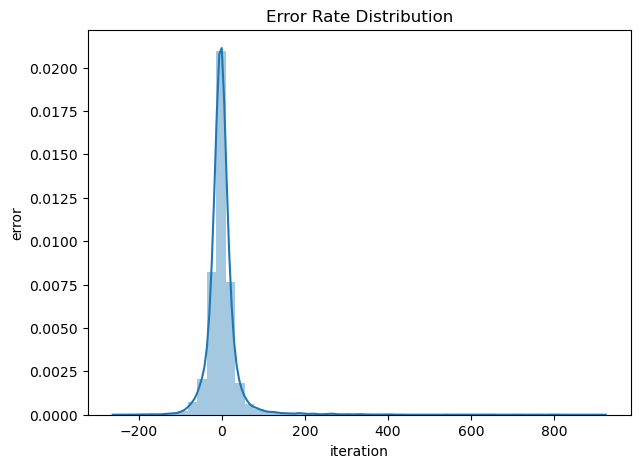

In [102]:
y_hat_tuned = catb.predict(X_test)
plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")
plt.show()

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


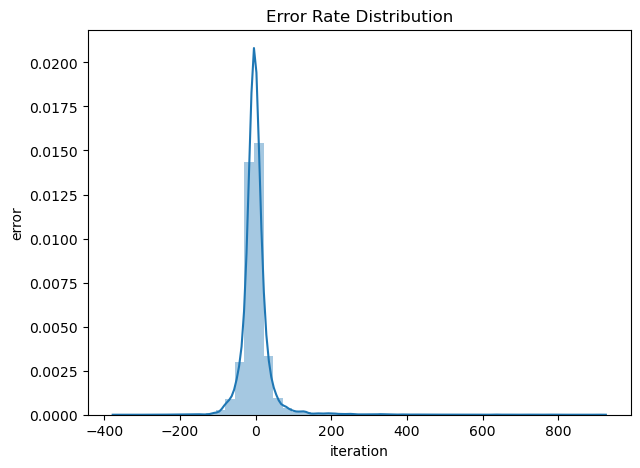

In [103]:
y_hat_tuned = rf_tuned_model.predict(X_test)
plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")
plt.show()

In [106]:
with open('/home/abhishek/Desktop/Site_EUI_Prediction/models/rf_tuned_final.joblib', 'wb') as f:
    joblib.dump(rf_tuned_model, f, compress=1)

with open('/home/abhishek/Desktop/Site_EUI_Prediction/model/catb_best_final.joblib', 'wb') as f:
    joblib.dump(catb,f,compress=3)

In [107]:
load = False
if load:
    with open('models/rf_tuned_final.joblib', 'rb') as f:
        rf = joblib.load(f)

    with open('model/catb_best_final.joblib', 'rb') as f:
        catb = joblib.load(f)

In [111]:
size = 2000
sample_exists = False
if sample_exists:
    sample_set = pd.read_csv('/home/abhishek/Desktop/Site_EUI_Prediction/data/shap/sample2000.csv')
else:
    sample_set = X_test.sample(2000)
sample_set

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
76887          6.0    252063.0      1979.0           40.000000       42.7   
60647          2.0     81649.0      1929.0           56.919640        3.4   
35643          1.0     55138.0      1936.0           62.000000       42.7   
44089          3.0     57279.0      2009.0            1.000000       11.9   
8168           6.0     61320.0      1926.0           56.000000       26.5   
...            ...         ...         ...                 ...        ...   
26645          5.0     62925.0      1972.0           60.691186      201.8   
37004          3.0     89328.0      1912.0           72.000000       15.2   
34720          3.0     72673.0      1972.0           43.000000       11.9   
66094          4.0    103852.0      1948.0           96.000000       42.7   
32729          5.0    136320.0      1889.0           78.000000       25.6   

       january_min_temp  january_avg_temp  january_max_temp  \
76887              11.0         34.451613              59.0   
60647              13.0         37.322581              62.0   
35643               6.0         29.677419              53.0   
44089              11.0         35.080645              61.0   
8168               28.0         43.451613              56.0   
...                 ...               ...               ...   
26645              -8.0         21.935484              46.0   
37004              11.0         35.080645              61.0   
34720              11.0         35.080645              61.0   
66094               4.0         28.596774              58.0   
32729               8.0         29.854839              56.0   

       february_min_temp  february_avg_temp  ...  avg_autumn_temp  \
76887               -1.0          37.706897  ...        61.591637   
60647               20.0          40.879310  ...        58.635006   
35643               15.0          36.035714  ...        59.890382   
44089               17.0          33.910714  ...        59.478913   
8168                34.0          47.672414  ...        56.563321   
...                  ...                ...  ...              ...   
26645              -13.0          15.696429  ...        55.407168   
37004               17.0          33.910714  ...        59.478913   
34720               17.0          33.910714  ...        59.478913   
66094                9.0          31.625000  ...        58.740263   
32729                2.0          23.946429  ...        61.920191   

       std_autumn_temp  skew_autumn_temp  month_cooling_degree_days  \
76887        19.839052          0.086495                 124.083333   
60647        19.428601          0.204298                 106.416667   
35643        19.081629         -0.009883                 110.916667   
44089        23.149084          0.108344                 106.000000   
8168         14.299158          0.209871                  21.666667   
...                ...               ...                        ...   
26645        25.495274         -0.288125                  64.083333   
37004        23.149084          0.108344                 106.000000   
34720        23.149084          0.108344                 106.000000   
66094        20.984169         -0.204013                  94.000000   
32729        21.052041          0.064321                 131.750000   

       month_heating_degree_days  building_area  floor_energy_star_rating  \
76887                 354.333333     10763090.1                  0.936768   
60647                 331.500000       277606.6                 16.741071   
35643                 361.250000      2354392.6                  1.451991   
44089                 389.166667       681620.1                  0.084034   
8168                  314.333333      1624980.0                  2.113208   
...                          ...            ...                       ...   
26645                 518.833333     12698265.0                  0.300749   
37004                 389.1

In [124]:
is_saved = False
if is_saved:
    with open('data/shap/shap_values_sample2000.pkl', 'rb') as f:
        shap_values = joblib.load(f)
else:
    shap_values = shap.TreeExplainer(catb).shap_values(sample_set)

In [114]:
shap.initjs()

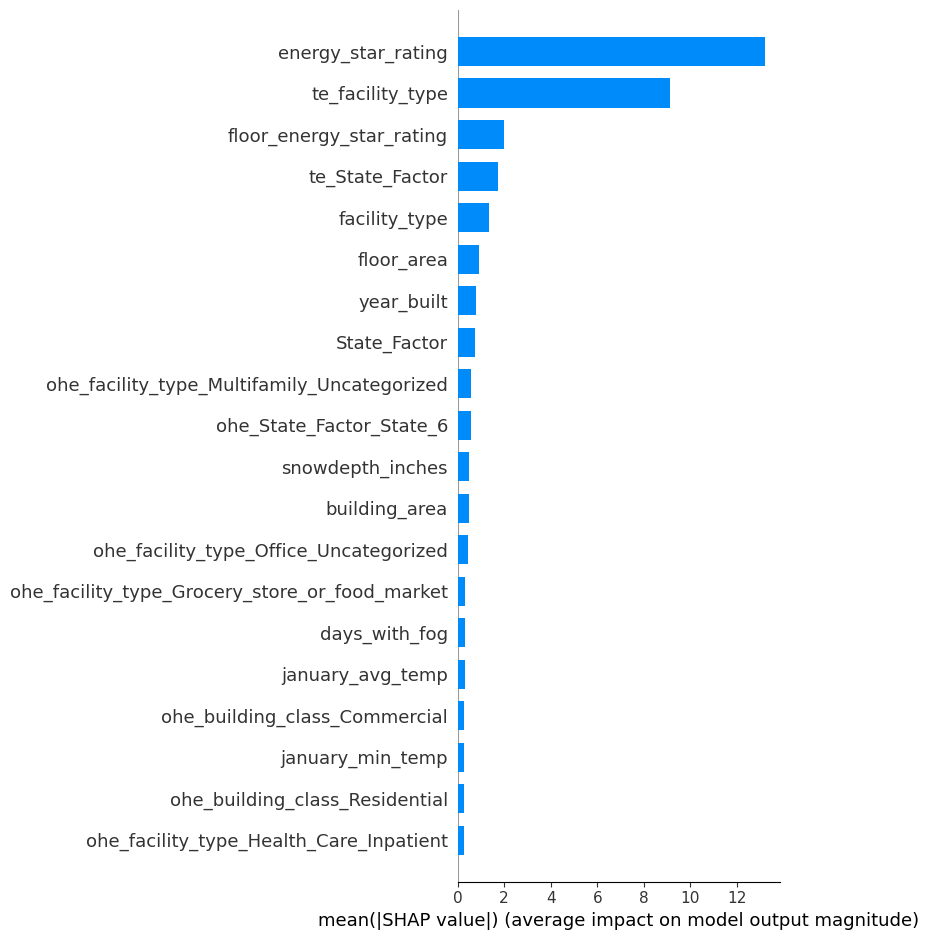

In [115]:
shap.summary_plot(shap_values, sample_set, plot_type="bar")

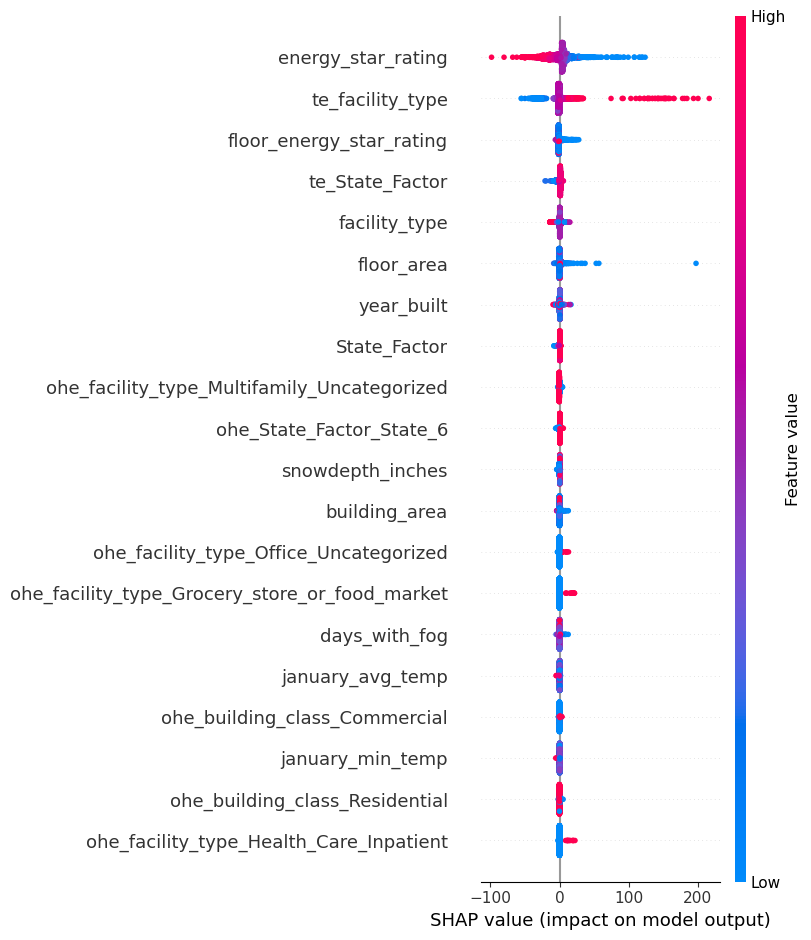

In [116]:
shap.summary_plot(shap_values, sample_set)

In [117]:
limit = 200
shap.force_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], shap_values[0:limit,:], sample_set.iloc[0:limit,:])

In [118]:
row = 60
print(y_pred[row])
shap.initjs()
shap.force_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], shap_values[row], sample_set.iloc[row])

53.94546185193466


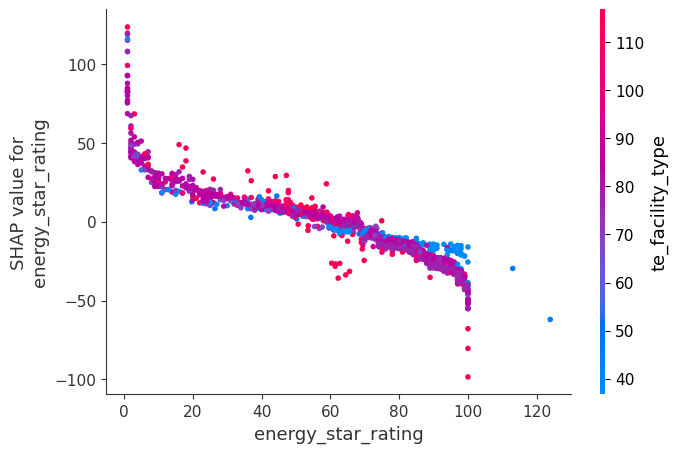

In [119]:
shap.dependence_plot('energy_star_rating', shap_values, sample_set)

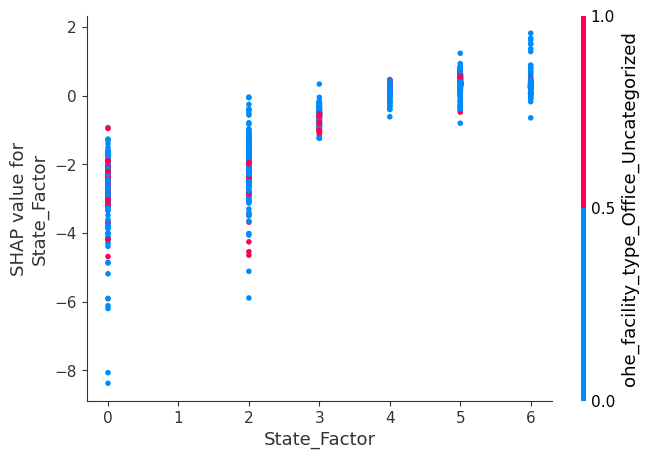

In [120]:
shap.dependence_plot('State_Factor', shap_values, sample_set)

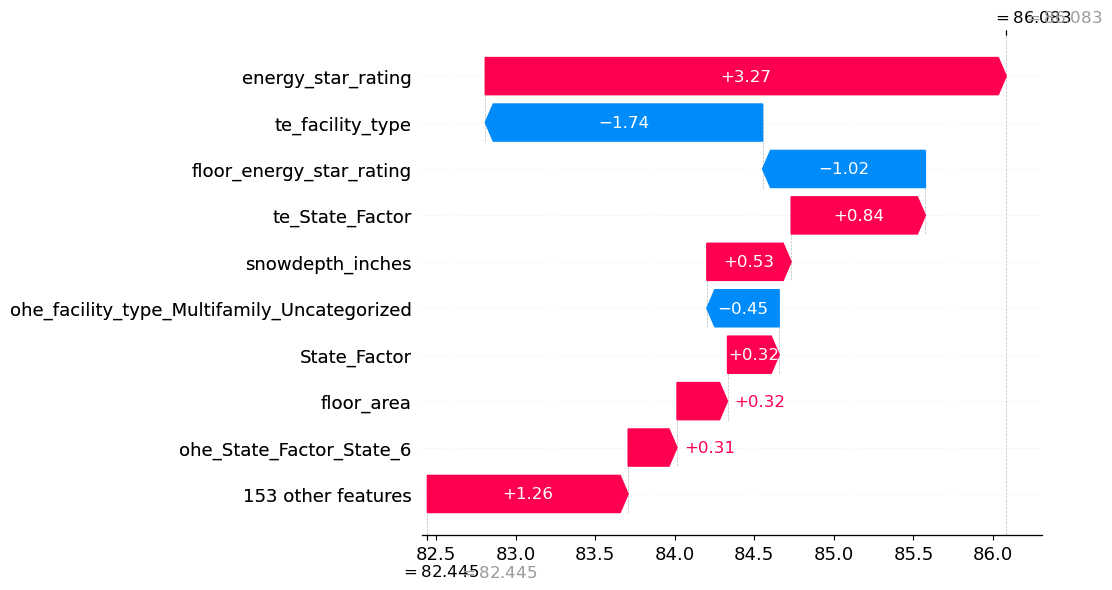

In [121]:
row = 111
shap.plots._waterfall.waterfall_legacy(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                                       shap_values[row],
                                       feature_names=sample_set.columns.tolist()
                                      )

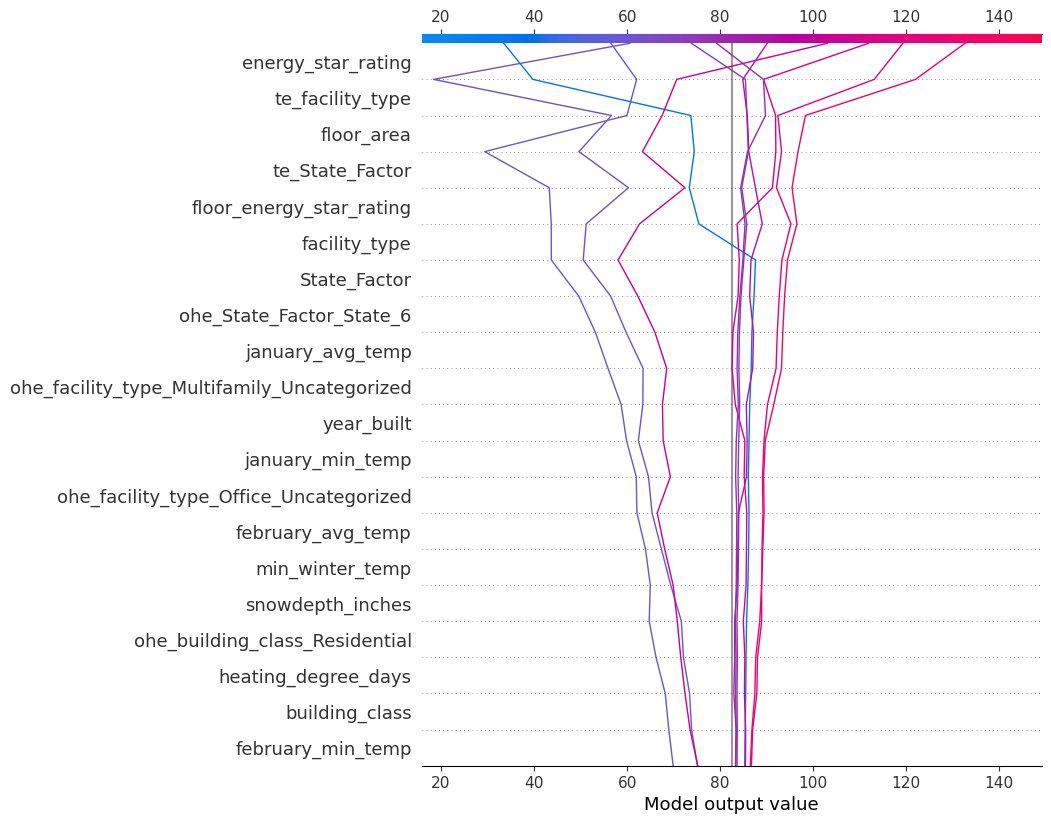

In [122]:
start = 120
limit = 130

shap.decision_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                   shap_values[start:limit], 
                   feature_names=sample_set.columns.tolist())

 98%|===================| 982/1000 [00:53<00:00]        

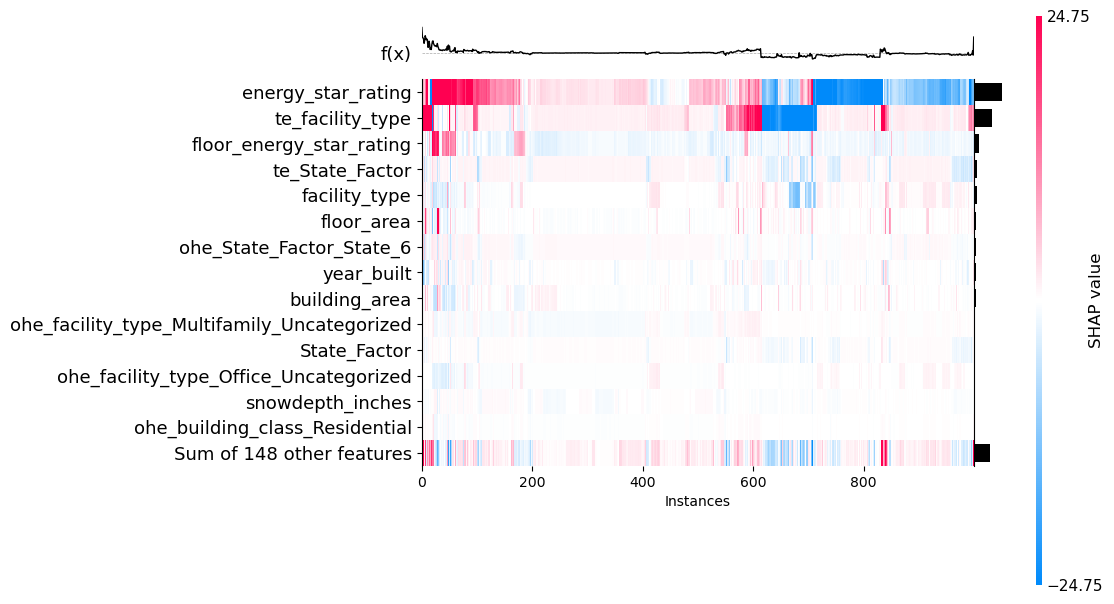

In [123]:
limit = 1000
shap.plots.heatmap(shap.TreeExplainer(rf_tuned_model, data=sample_set)(sample_set[:limit]), max_display=15)